# Coding 1 & Data Analysis 2 - Home Assignment 2
### Authors: Gréta Zsikla & Márton Nagy

Importing the needed packages.

In [3]:
import pandas as pd
import math
import numpy as np
from plotnine import *
import patchworklib as pw
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
from datetime import timedelta
import scipy.stats as stats
from IPython.display import display
from mizani.formatters import percent_format
import copy
import statsmodels.nonparametric.kernel_regression as loess
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

<Figure size 100x100 with 0 Axes>

## Importing the raw data files

Reading the raw Excel-sheet, as downloaded from TEIR.

In [5]:
raw = pd.read_excel('https://github.com/marton-nagy-marton/DA2_assignment2/raw/refs/heads/main/source_data_teir_ksh.xlsx', sheet_name='raw')

Renaming the indicators to be computer friendly and transposing the DataFrame.

In [7]:
indicators_renamed = [
    "muni_name",
    "comm_work",
    "romani_pctg",
    "dependence_rate",
    "pop",
    "pop_15_64f",
    "pop_15_64m",
    "county_center_min",
    "hprest_emp_pctg",
    "unemp_pctg",
    "area",
    "roads_undev",
    "roads_dev",
    "roads_total",
    "income",
    "gp_visits",
    "elem_students",
    "disadv_elem_students",
    "crime_per1000people",
    "low_comf_housing",
    "educ_level_max_elem",
    "migration_per1000",
    "growth_decline_per1000",
    "elem_stud_from_other_muni_pctg",
    "pop_65-x_m",
    "pop_65-x_f",
    "people_in_agriculture",
    "employed",
    "pop_7_x"
]
tidy = raw.iloc[:,1:].T
tidy.reset_index(drop = False, inplace = True)
tidy.columns = indicators_renamed
tidy

,muni_name,comm_work,romani_pctg,dependence_rate,pop,pop_15_64f,pop_15_64m,county_center_min,hprest_emp_pctg,unemp_pctg,...,low_comf_housing,educ_level_max_elem,migration_per1000,growth_decline_per1000,elem_stud_from_other_muni_pctg,pop_65-x_m,pop_65-x_f,people_in_agriculture,employed,pop_7_x
0,Aba (1737),10.0,0.41,47.89,4633.0,1662.0,1797.0,20.48,12.25,51.81,...,5.89,1188.0,-3.82,-3.14,12.87,255.0,439.0,22.0,2366.0,4051.0
1,Abádszalók (1244),136.0,4.24,56.27,4180.0,1402.0,1570.0,61.78,15.33,44.59,...,10.96,982.0,5.17,-13.97,17.77,366.0,514.0,10.0,1688.0,3608.0
2,Abaliget (1254),13.0,8.57,57.18,659.0,234.0,251.0,22.75,26.47,37.50,...,6.34,99.0,-24.04,-1.60,47.19,44.0,59.0,1.0,323.0,572.0
3,Abasár * (2455),4.0,0.51,59.62,2540.0,817.0,938.0,44.45,19.81,49.43,...,5.27,442.0,28.49,-18.99,29.21,229.0,350.0,4.0,1270.0,2359.0
4,Abaújalpár (1566),5.0,NaN,39.13,67.0,28.0,26.0,46.28,20.00,100.00,...,NaN,21.0,0.00,0.00,NaN,3.0,8.0,0.0,30.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3150,Zsennye (1229),NaN,NaN,80.36,106.0,31.0,33.0,29.62,21.05,60.00,...,NaN,17.0,0.00,0.00,NaN,15.0,17.0,0.0,39.0,82.0
3151,Zsira (462),NaN,0.35,48.82,850.0,302.0,300.0,78.09,21.60,NaN,...,4.98,187.0,23.34,-25.80,50.78,72.0,96.0,0.0,412.0,819.0
3152,Zsombó (1776),4.0,0.15,50.25,3574.0,1259.0,1380.0,20.08,26.74,40.00,...,8.22,626.0,12.91,0.90,13.43,283.0,338.0,6.0,1778.0,3124.0
3153,Zsujta (1102),11.0,16.74,102.75,239.0,63.0,67.0,51.14,11.84,73.33,...,16.48,79.0,307.29,-46.88,NaN,22.0,64.0,1.0,79.0,204.0


Extracting the municipality ID and municipality name from the raw data.

In [9]:
tidy['muni_id'] = tidy['muni_name'].apply(lambda x: int(x.split('(')[-1].split(')')[0]))
tidy['muni_name'] = tidy['muni_name'].apply(lambda x: x.replace(' *', '').split(' (')[0])

We connect the data using the municipality names to an administrative dataset on the status, counties and districts of each municipality. This is the 'Helységnévtár' sheet downloaded from KSH.

In [11]:
status = pd.read_excel('https://github.com/marton-nagy-marton/DA2_assignment2/raw/refs/heads/main/source_data_teir_ksh.xlsx', sheet_name='hnt', skiprows = 2)
merged = tidy.merge(status, how = 'inner', left_on='muni_name', right_on='Helység megnevezése')
tidy['status'] = merged['Helység jogállása'].str.strip()
tidy['county'] = merged['Vármegye megnevezése'].str.strip()
tidy['district'] = merged['Járás neve'].str.strip()

## Data cleaning and dealing with missing values

Applying some cleaning to the status column: we create a dummy for the municipality being a county center.

In [13]:
tidy['status'].unique()

array(['város', 'község', 'nagyközség', 'megyei jogú város',
       'megyeszékhely, megyei jogú város', 'főváros'], dtype=object)

In [14]:
tidy['is_county_center'] = tidy['status'].apply(lambda x: 1 if x in ['megyeszékhely, megyei jogú város', 'főváros'] else 0)

In [15]:
tidy['status'] = tidy['status'].apply(lambda x: 'megyei jogú város' if x == 'megyeszékhely, megyei jogú város' else x)

Reordering the columns.

In [17]:
tidy = tidy.filter(['muni_id','muni_name','status','is_county_center','county','district','comm_work','romani_pctg','dependence_rate','pop','pop_15_64f','pop_15_64m',
              'county_center_min','hprest_emp_pctg','unemp_pctg','area','roads_undev','roads_dev','roads_total','income','gp_visits',
              'elem_students','disadv_elem_students','crime_per1000people','low_comf_housing','educ_level_max_elem',
              'migration_per1000','growth_decline_per1000','elem_stud_from_other_muni_pctg','pop_65-x_m','pop_65-x_f','people_in_agriculture',
              'employed', 'pop_7_x'])

Now let's inspect the DataFrame to see the number of missing values by variable.

In [19]:
tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3155 entries, 0 to 3154
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   muni_id                         3155 non-null   int64  
 1   muni_name                       3155 non-null   object 
 2   status                          3155 non-null   object 
 3   is_county_center                3155 non-null   int64  
 4   county                          3154 non-null   object 
 5   district                        3154 non-null   object 
 6   comm_work                       2914 non-null   float64
 7   romani_pctg                     2352 non-null   float64
 8   dependence_rate                 3155 non-null   float64
 9   pop                             3155 non-null   float64
 10  pop_15_64f                      3155 non-null   float64
 11  pop_15_64m                      3155 non-null   float64
 12  county_center_min               31

Now let's deal with missing values for each variable.

In [21]:
tidy[tidy['county'].isna()]

,muni_id,muni_name,status,is_county_center,county,district,comm_work,romani_pctg,dependence_rate,pop,...,low_comf_housing,educ_level_max_elem,migration_per1000,growth_decline_per1000,elem_stud_from_other_muni_pctg,pop_65-x_m,pop_65-x_f,people_in_agriculture,employed,pop_7_x
393,1357,Budapest,főváros,1,NaN,NaN,510.0,0.77,51.02,1630320.0,...,1.2,202503.0,-3.02,-4.69,9.16,136116.0,226702.0,1192.0,913266.0,1590653.0


It turns out that the capital does not have statistically a district and a county. For our purposes, let's change this by assigning Budapest as a county and a district.

In [23]:
tidy['county'] = tidy['county'].fillna('Budapest')
tidy['district'] = tidy['district'].fillna('Budapest')

For the quantitative variables, let's look at the descriptive statistics first.

In [25]:
desc_na = tidy.iloc[:,6:].describe().T
desc_na[desc_na['count'] != 3155]

,count,mean,std,min,25%,50%,75%,max
comm_work,2914.0,26.140014,48.085477,1.00,4.0000,10.000,26.7500,734.00
romani_pctg,2352.0,5.968274,9.497803,0.09,0.8000,2.440,6.9725,90.16
county_center_min,3136.0,44.438712,20.391054,6.80,29.3875,42.030,56.3025,144.94
hprest_emp_pctg,3152.0,15.747018,8.595697,0.43,10.0800,13.760,19.4800,73.91
unemp_pctg,3023.0,54.358951,16.616119,7.69,43.8000,54.050,63.6650,100.00
roads_undev,2889.0,5.372918,12.960453,0.01,1.0500,2.230,5.3100,304.58
roads_dev,3109.0,13.611039,88.040840,0.01,2.2000,4.890,11.3400,4643.50
roads_total,3141.0,18.414225,95.542847,0.05,3.6500,7.660,16.4200,4948.08
elem_students,1742.0,410.536739,2950.346566,5.00,88.0000,146.000,250.7500,117627.00
disadv_elem_students,1430.0,26.660839,45.338232,1.00,5.0000,14.000,33.0000,1034.00


As we can see, most of the variables have a larger than 0 minimum, which is suspicious. The reason for this is most apparent in the case of county_center_min: missing values should actually be zero!

In [27]:
tidy[tidy['county_center_min'].isna()][['muni_name', 'is_county_center']]

,muni_name,is_county_center
251,Békéscsaba,1
393,Budapest,1
556,Debrecen,1
660,Eger,1
919,Győr,1
1199,Kaposvár,1
1241,Kecskemét,1
1738,Miskolc,1
1966,Nyíregyháza,1
2127,Pécs,1


As we can see, the only missing values are for those municipalities that are county centers themselves.

We decided to impute missing values with zero for the every variable except: roads_total, roads_undev, roads_dev, students_from_other_village_pctg, and pop_7_x. We will get back to these variables later.

In [30]:
tidy[['comm_work', 'romani_pctg', 'dependence_rate', 'pop', 'pop_15_64f', 'pop_15_64m',
      'county_center_min', 'hprest_emp_pctg', 'unemp_pctg', 'area', 'income', 'gp_visits',
      'elem_students', 'disadv_elem_students', 'crime_per1000people', 
      'low_comf_housing', 'educ_level_max_elem', 'migration_per1000', 'growth_decline_per1000', 
      'pop_65-x_m', 'pop_65-x_f', 'people_in_agriculture', 'employed']] = \
tidy[['comm_work', 'romani_pctg', 'dependence_rate', 'pop', 'pop_15_64f', 'pop_15_64m',
      'county_center_min', 'hprest_emp_pctg', 'unemp_pctg', 'area', 'income', 'gp_visits',
      'elem_students', 'disadv_elem_students', 'crime_per1000people', 
      'low_comf_housing', 'educ_level_max_elem', 'migration_per1000', 'growth_decline_per1000', 
      'pop_65-x_m', 'pop_65-x_f', 'people_in_agriculture', 'employed']].fillna(0)


For the roads variables, it is not quite obvious what the missing values represent, even though the minima are never zero. E.g. for some municipalities the total is given but there is no breakdown whether the roads are developed or undeveloped. Also, these variables give information only about roads managed by the municipality government. So, we have decided not to include these variables in our analysis as it was ambigous how we should treat missing values (and there were a lot of missing values).

For the population above 7 years of age, it is unplausible that there is a municipality where there are no people above 7. However, as only one observation is missing, we can simply exclude that.

For the percentage of students from other municipalities, the minimum is already zero. This indicates that there are students in that municipality, but there are no students from other municipalities. So, this variable should only be missing if there are no students in that municipality, as then we would have to divide by zero. We can check if this is the case.

In [32]:
tidy.shape

(3155, 34)

In [33]:
tidy.drop(columns = ['roads_undev','roads_dev','roads_total'], inplace = True)
tidy = tidy[tidy['pop_7_x'].notna()]

In [34]:
tidy.shape

(3154, 31)

Below, we can see that indeed, the percentage of students from other municipalities is only missing if the number of elementary students is zero. So these missing values make sense - thus we shall leave them as is for now.

In [36]:
tidy[(tidy['elem_students'] != 0) & tidy['elem_stud_from_other_muni_pctg'].isna()][['muni_name', 'elem_students', 'elem_stud_from_other_muni_pctg']]

,muni_name,elem_students,elem_stud_from_other_muni_pctg


Now we can create some new variables. What we do is basically two things:
- convert percentages to ratio variables,
- and calculate ratio variables (e.g. per capita, per employed people) by dividing with a sensible reference group.

In [38]:
tidy['pop_15_64'] = tidy['pop_15_64m'] + tidy['pop_15_64f']
tidy['pop_65_x'] = tidy['pop_65-x_m'] + tidy['pop_65-x_f']
tidy['pop_density'] = tidy['pop'] / tidy['area']
tidy['old_age_dependency_ratio'] = tidy['pop_65_x'] / tidy['pop_15_64']
tidy['gen_dependency_ratio'] = tidy['dependence_rate'] / 100
tidy['comm_work_per_employed'] = tidy['comm_work'] / tidy['employed']
tidy['monthly_income_pc'] = tidy['income'] / tidy['pop'] / 12
tidy['max_elem_educ_ratio'] = tidy['educ_level_max_elem'] / tidy['pop_7_x']
tidy['agr_emp_ratio'] = tidy['people_in_agriculture'] / tidy['employed']
tidy['disadv_elem_students_ratio'] =  tidy['disadv_elem_students'] / tidy['elem_students']
tidy['avg_gp_visits_pc'] = tidy['gp_visits'] / tidy['pop']
tidy['romani_ratio'] = tidy['romani_pctg'] / 100
tidy['hprest_emp_ratio'] = tidy['hprest_emp_pctg'] / 100
tidy['unemp_ratio'] = tidy['unemp_pctg'] / 100
tidy['elem_stud_from_other_muni_ratio'] = tidy['elem_stud_from_other_muni_pctg'] / 100
tidy['low_comf_housing_ratio'] = tidy['low_comf_housing'] / 100

In [39]:
tidy = tidy.filter([
    'muni_id',
    'muni_name',
    'status',
    'is_county_center',
    'county',
    'district',
    'comm_work_per_employed',
    'romani_ratio',
    'monthly_income_pc',
    'unemp_ratio',
    'hprest_emp_ratio',
    'agr_emp_ratio',
    'pop_density',
    'old_age_dependency_ratio',
    'gen_dependency_ratio',
    'migration_per1000',
    'growth_decline_per1000',
    'max_elem_educ_ratio',
    'disadv_elem_students_ratio',
    'elem_stud_from_other_muni_ratio',
    'county_center_min',
    'low_comf_housing_ratio',
    'crime_per1000people',
    'avg_gp_visits_pc',
    'pop',
    'area'
])

In [40]:
tidy.iloc[:,5:].describe().T

,count,mean,std,min,25%,50%,75%,max
comm_work_per_employed,3154.0,0.060158,0.090473,0.000000,0.006509,0.025499,0.077306,9.723757e-01
romani_ratio,3154.0,0.044507,0.086034,0.000000,0.000000,0.011650,0.046900,9.016000e-01
monthly_income_pc,3154.0,144094.057371,44823.142441,20377.844887,112652.492078,141648.685080,172594.374752,4.901384e+05
unemp_ratio,3154.0,0.521012,0.195523,0.000000,0.421100,0.529400,0.633300,1.000000e+00
hprest_emp_ratio,3154.0,0.157226,0.085904,0.000000,0.100725,0.137600,0.194375,7.391000e-01
agr_emp_ratio,3154.0,0.011689,0.017606,0.000000,0.001330,0.005797,0.014794,1.764706e-01
pop_density,3154.0,73.549782,133.183612,1.515152,25.833222,42.381289,72.074074,3.104603e+03
old_age_dependency_ratio,3154.0,0.273532,0.089486,0.034063,0.220081,0.261092,0.313575,1.085106e+00
gen_dependency_ratio,3154.0,0.547398,0.093281,0.115400,0.494600,0.539850,0.590675,1.750000e+00
migration_per1000,3154.0,0.305371,33.919665,-514.290000,-13.352500,0.285000,15.087500,3.072900e+02


There is one thing left to do for dealing with missing values. We shall set the student ratio variables to 0 if they are missing (remember, this indicated that there are no elementary students in that municipality), but we should also create a dummy flag to capture this.

In [42]:
tidy['no_elem_stud'] = tidy['disadv_elem_students_ratio'].apply(lambda x: 1 if pd.isna(x) else 0)

In [43]:
tidy[['disadv_elem_students_ratio', 'elem_stud_from_other_muni_ratio']] = tidy[['disadv_elem_students_ratio', 'elem_stud_from_other_muni_ratio']].fillna(0)

We have decided to exclude Budapest, the capital of Hungary of the analysis, as we do not have district-level data on it, without which analysing it is kind of meaningless.

In [45]:
tidy = tidy[tidy['muni_name'] != 'Budapest']

## Exploratory data analysis

In [47]:
tidy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3153 entries, 0 to 3154
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   muni_id                          3153 non-null   int64  
 1   muni_name                        3153 non-null   object 
 2   status                           3153 non-null   object 
 3   is_county_center                 3153 non-null   int64  
 4   county                           3153 non-null   object 
 5   district                         3153 non-null   object 
 6   comm_work_per_employed           3153 non-null   float64
 7   romani_ratio                     3153 non-null   float64
 8   monthly_income_pc                3153 non-null   float64
 9   unemp_ratio                      3153 non-null   float64
 10  hprest_emp_ratio                 3153 non-null   float64
 11  agr_emp_ratio                    3153 non-null   float64
 12  pop_density              

In [48]:
tidy.iloc[:,5:].describe(percentiles=[0.05,0.25, 0.5, 0.75, 0.95]).T.applymap(lambda x: format(x, '.4f'))

,count,mean,std,min,5%,25%,50%,75%,95%,max
comm_work_per_employed,3153.0000,0.0602,0.0905,0.0000,0.0000,0.0065,0.0255,0.0773,0.2343,0.9724
romani_ratio,3153.0000,0.0445,0.0860,0.0000,0.0000,0.0000,0.0117,0.0469,0.2103,0.9016
monthly_income_pc,3153.0000,144059.0265,44787.0495,20377.8449,75687.0282,112648.1990,141647.3822,172535.5437,221016.7282,490138.4280
unemp_ratio,3153.0000,0.5210,0.1956,0.0000,0.1667,0.4211,0.5294,0.6333,0.8107,1.0000
hprest_emp_ratio,3153.0000,0.1571,0.0858,0.0000,0.0544,0.1007,0.1376,0.1943,0.3239,0.7391
agr_emp_ratio,3153.0000,0.0117,0.0176,0.0000,0.0000,0.0013,0.0058,0.0148,0.0436,0.1765
pop_density,3153.0000,72.5885,121.7696,1.5152,11.5497,25.8322,42.3745,72.0000,218.3228,2094.4079
old_age_dependency_ratio,3153.0000,0.2735,0.0895,0.0341,0.1563,0.2200,0.2611,0.3135,0.4314,1.0851
gen_dependency_ratio,3153.0000,0.5474,0.0933,0.1154,0.4192,0.4946,0.5399,0.5907,0.6962,1.7500
migration_per1000,3153.0000,0.3064,33.9250,-514.2900,-48.1060,-13.3600,0.3100,15.0900,46.3200,307.2900


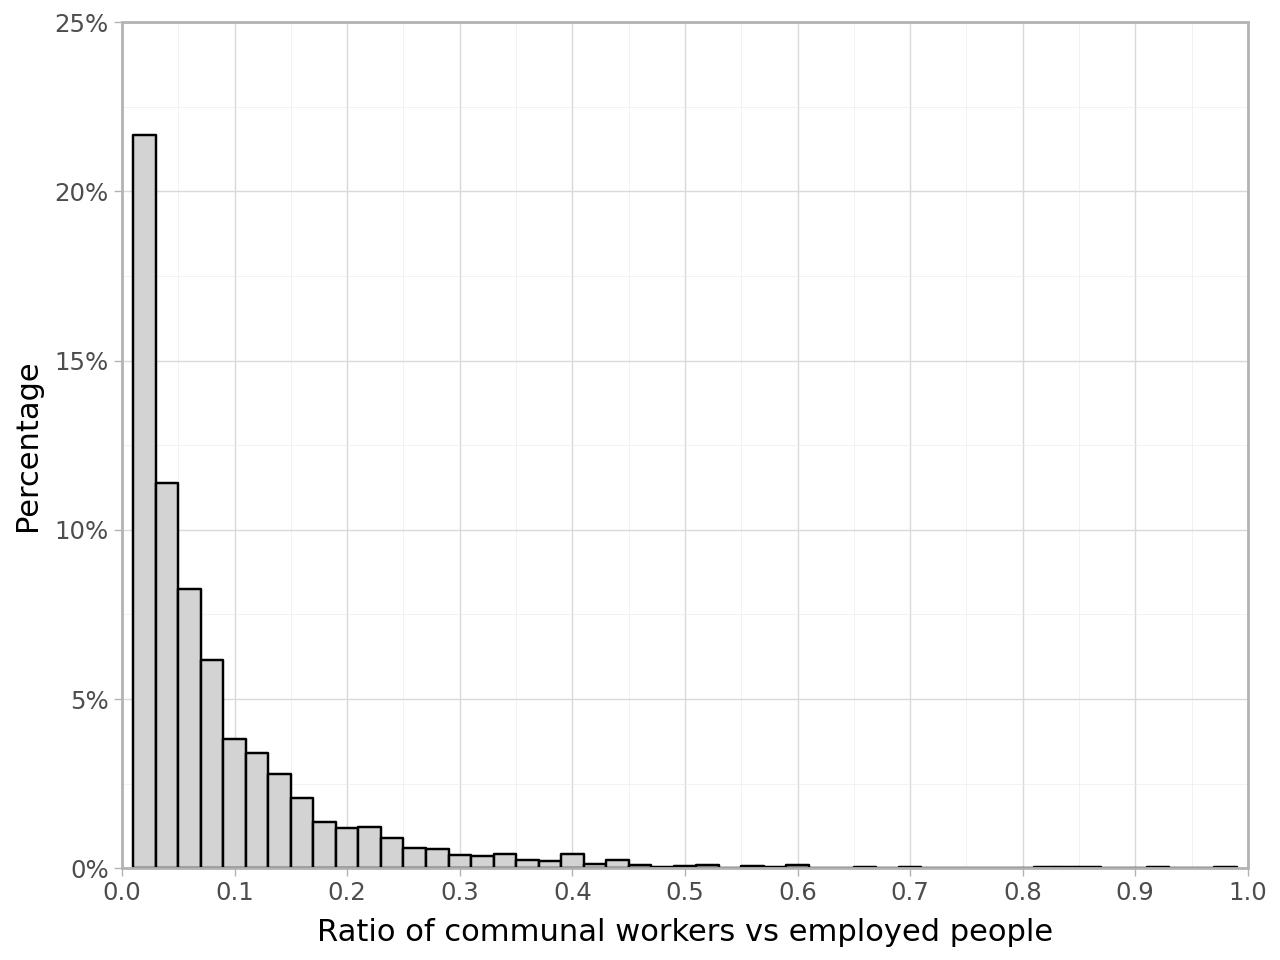

In [49]:
(
    ggplot(tidy)
    + aes(x = 'comm_work_per_employed')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.02
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 1),
        breaks= np.arange(0, 1.1,0.1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.25),
        breaks=np.arange(0,0.30,0.05),
        labels=percent_format()
    )
    + labs(
        x = 'Ratio of communal workers vs employed people',
        y = 'Percentage'
    )
    + theme_light()
)

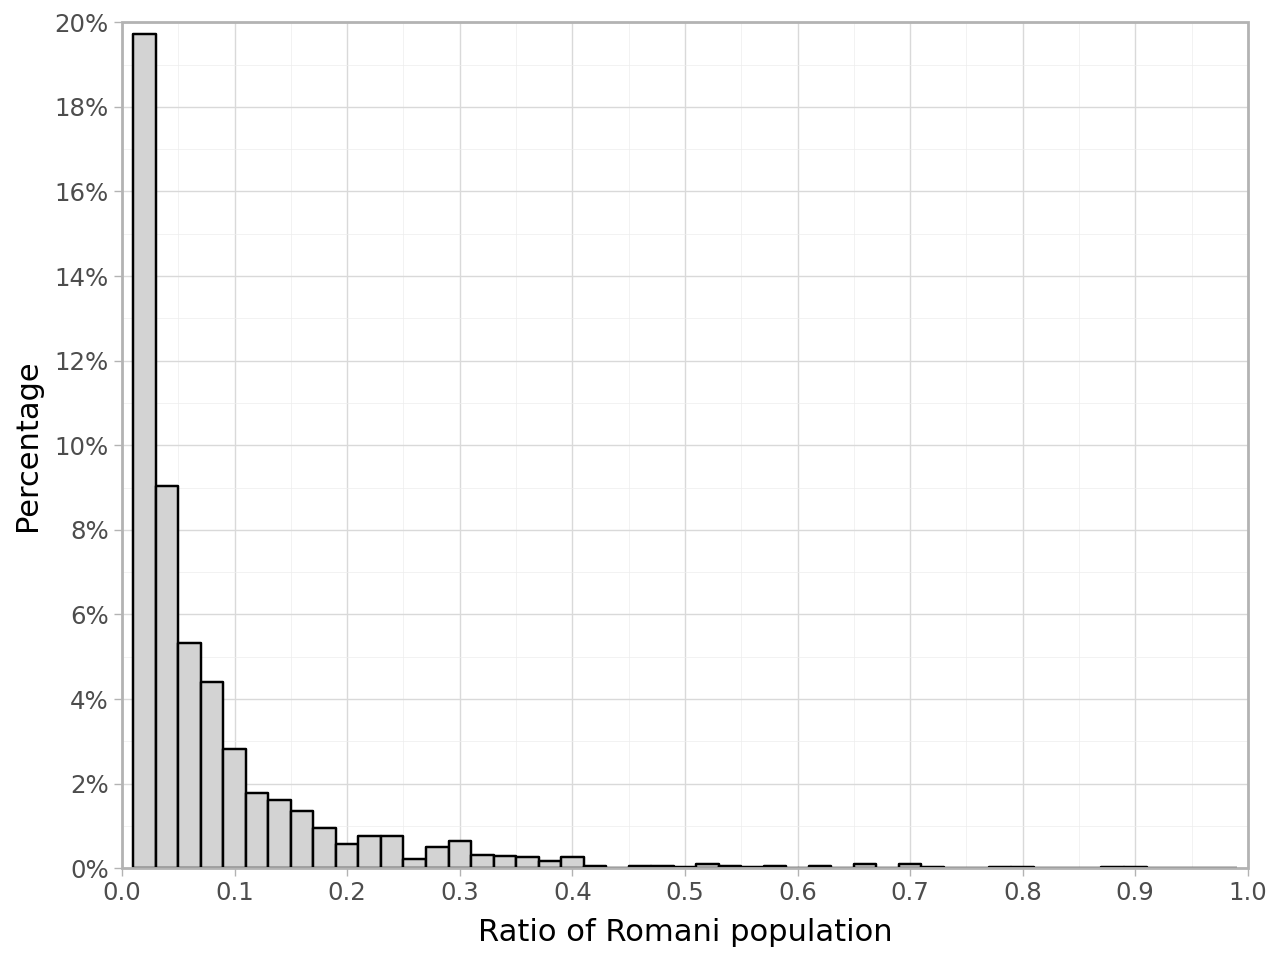

In [51]:
(
    ggplot(tidy)
    + aes(x = 'romani_ratio')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.02
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 1),
        breaks= np.arange(0, 1.1,0.1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.2),
        breaks=np.arange(0,0.22,0.02),
        labels=percent_format()
    )
    + labs(
        x = 'Ratio of Romani population',
        y = 'Percentage'
    )
    + theme_light()
)

From the above histograms, it seems that both of our variables of interest have a very long right tail. However, there are also a significant amount of zero values as well. So, how should we handle this? We cannot simply drop all observations where either of the variables is zero, as we would end up with only 886 observations instead of 3153.

Our idea was the following:
- estimate two regression models: a probability model for the whole sample, where we predict the probability of the municipality having communal workers, and a regular OLS model for a subsample for municipalities where there are communal workers (here we can take the log as well);
- and we take the log of the Romani population by: (1) assigning a small, but positive value before taking the log, and (2) creating a flag to indicate whether the initial value was actually zero.

In [53]:
tidy['ln_romani_ratio'] = tidy['romani_ratio'].apply(
    lambda x: np.log(np.min(tidy[tidy['romani_ratio'] != 0].romani_ratio)*0.5)
    if x == 0
    else np.log(x))
tidy['romani_zero_flag'] = tidy['romani_ratio'].apply(lambda x: 1 if x == 0 else 0)
#note that this creates missing values, but that's fine, as we will only use this if it is not mising
tidy['ln_comm_work_per_employed'] =  tidy['comm_work_per_employed'].apply(lambda x: np.log(x) if x != 0 else np.nan)
tidy['has_comm_worker'] = tidy['comm_work_per_employed'].apply(lambda x: 1 if x != 0 else 0)

As we can see, the distribution of log(romani ratio) is better, but still not optimal - but this is the best we can do if we want our coefficients to remain interpretable.

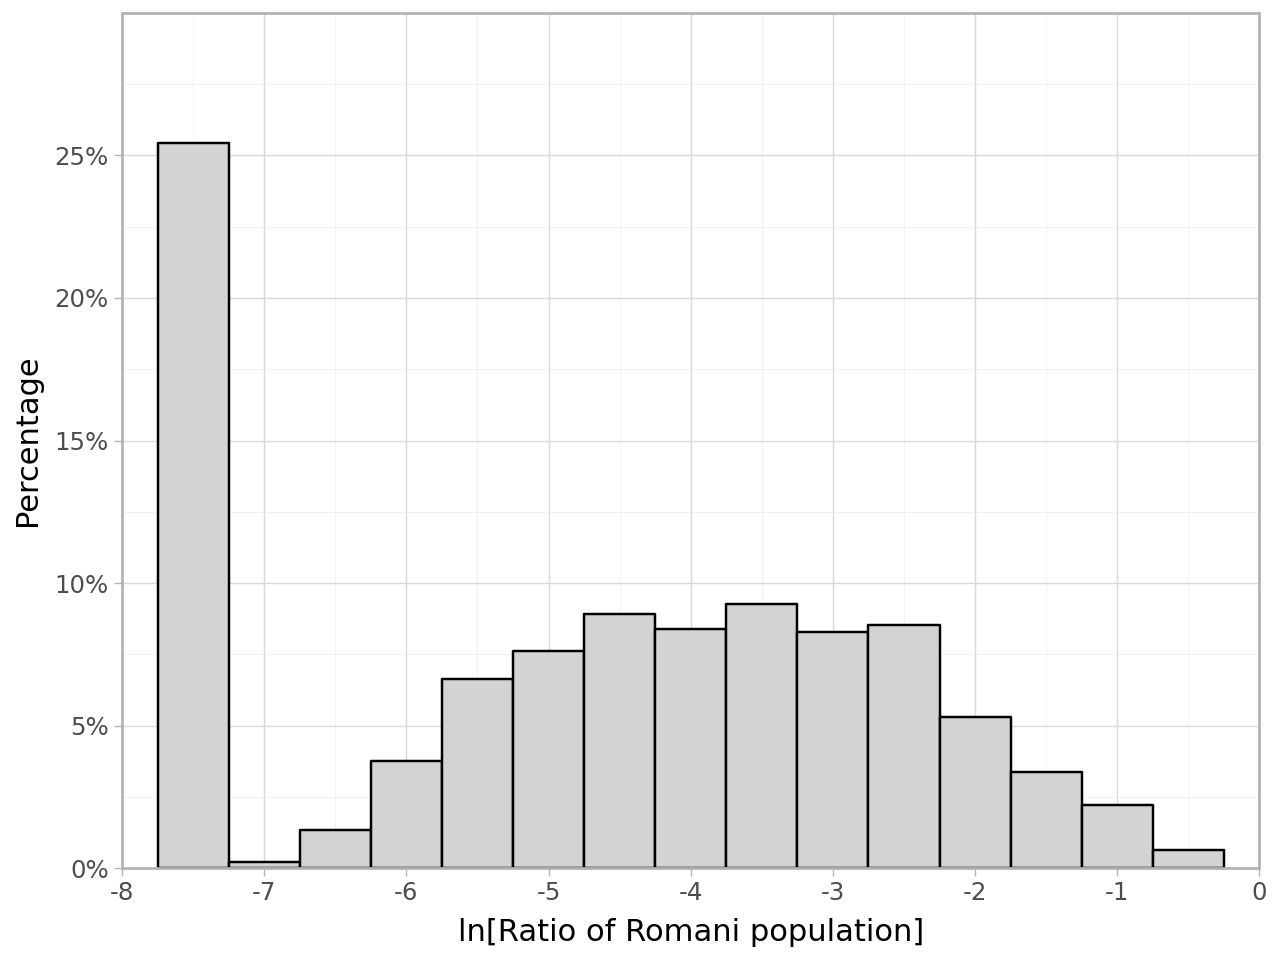

In [55]:
(
    ggplot(tidy)
    + aes(x = 'ln_romani_ratio')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.5
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(-8, 0),
        breaks= np.arange(-8, 1, 1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.3),
        breaks=np.arange(0,0.35,0.05),
        labels=percent_format()
    )
    + labs(
        x = 'ln[Ratio of Romani population]',
        y = 'Percentage'
    )
    + theme_light()
)

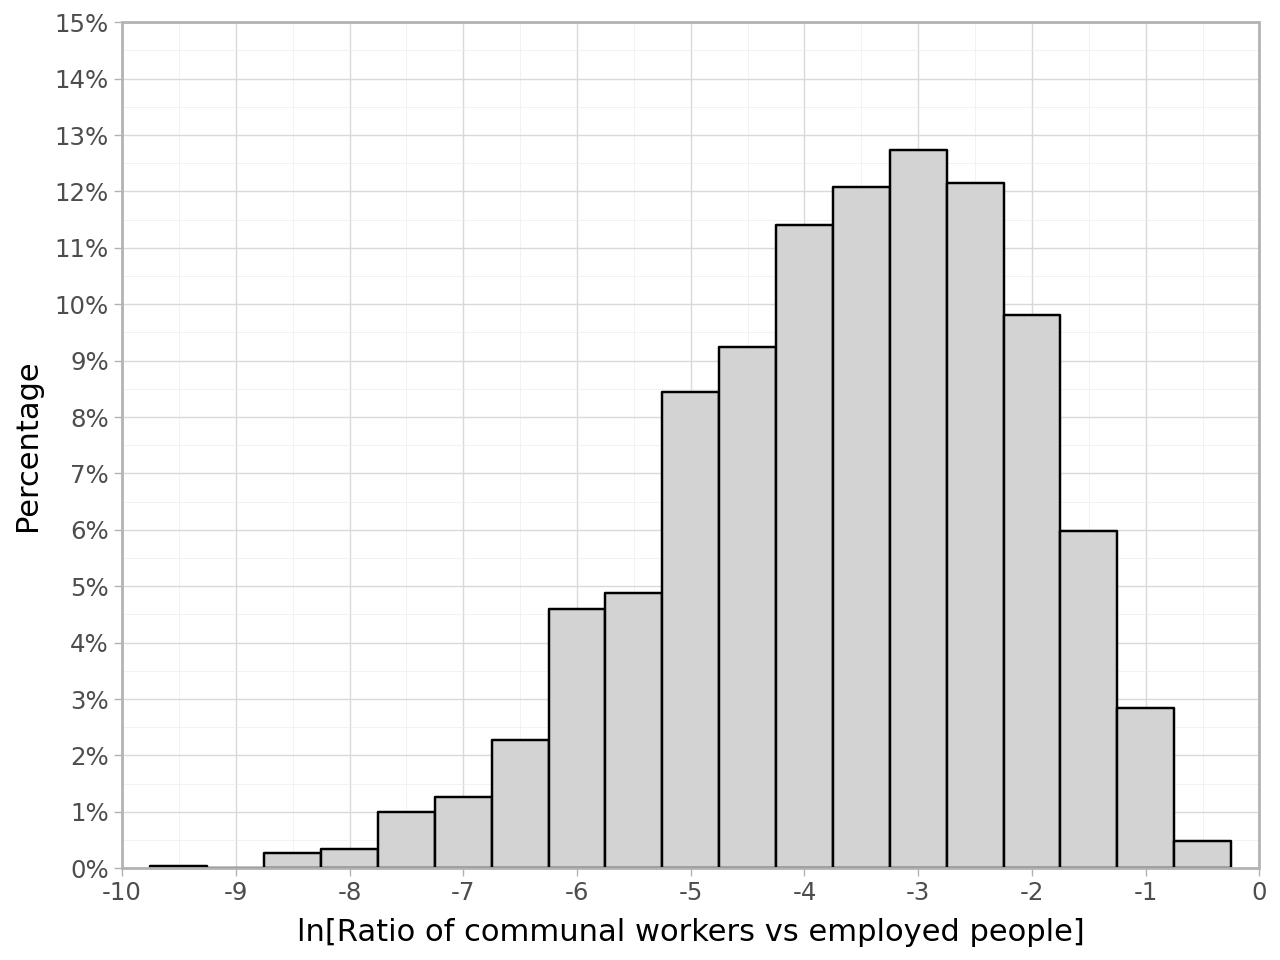

In [56]:
(
    ggplot(tidy)
    + aes(x = 'ln_comm_work_per_employed')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.5
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(-10, 0),
        breaks= np.arange(-10, 1, 1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.15),
        breaks=np.arange(0,0.16,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'ln[Ratio of communal workers vs employed people]',
        y = 'Percentage'
    )
    + theme_light()
)

We can also take the log of all other variables that are strictly positive, as the summary statistics showed that these are also somewhat skewed. However, we leave all other variables unchanged, as we only want to include them as controls, so it does not really matter if their coefficients are somewhat unprecise.

In [58]:
tidy['ln_monthly_income_pc'] = np.log(tidy['monthly_income_pc'])
tidy['ln_pop_density'] = np.log(tidy['pop_density'])
tidy['ln_old_age_dependency_ratio'] = np.log(tidy['old_age_dependency_ratio'])
tidy['ln_gen_dependency_ratio'] = np.log(tidy['gen_dependency_ratio'])
tidy['ln_avg_gp_visits_pc'] = np.log(tidy['avg_gp_visits_pc'])
tidy['ln_pop'] = np.log(tidy['pop'])
tidy['ln_area'] = np.log(tidy['area'])

Finally, let's take a look at the summar statistics.

In [60]:
tidy.iloc[:,5:].describe(percentiles=[0.05,0.25, 0.5, 0.75, 0.95]).T.applymap(lambda x: format(x, '.4f'))

,count,mean,std,min,5%,25%,50%,75%,95%,max
comm_work_per_employed,3153.0000,0.0602,0.0905,0.0000,0.0000,0.0065,0.0255,0.0773,0.2343,0.9724
romani_ratio,3153.0000,0.0445,0.0860,0.0000,0.0000,0.0000,0.0117,0.0469,0.2103,0.9016
monthly_income_pc,3153.0000,144059.0265,44787.0495,20377.8449,75687.0282,112648.1990,141647.3822,172535.5437,221016.7282,490138.4280
unemp_ratio,3153.0000,0.5210,0.1956,0.0000,0.1667,0.4211,0.5294,0.6333,0.8107,1.0000
hprest_emp_ratio,3153.0000,0.1571,0.0858,0.0000,0.0544,0.1007,0.1376,0.1943,0.3239,0.7391
agr_emp_ratio,3153.0000,0.0117,0.0176,0.0000,0.0000,0.0013,0.0058,0.0148,0.0436,0.1765
pop_density,3153.0000,72.5885,121.7696,1.5152,11.5497,25.8322,42.3745,72.0000,218.3228,2094.4079
old_age_dependency_ratio,3153.0000,0.2735,0.0895,0.0341,0.1563,0.2200,0.2611,0.3135,0.4314,1.0851
gen_dependency_ratio,3153.0000,0.5474,0.0933,0.1154,0.4192,0.4946,0.5399,0.5907,0.6962,1.7500
migration_per1000,3153.0000,0.3064,33.9250,-514.2900,-48.1060,-13.3600,0.3100,15.0900,46.3200,307.2900


## Non-parametric regression analysis

For the binary-outcome set up, we can see a linear relationship until ln_romani_ratio = 4.5. After that, the loess curve shows practically no relationship.

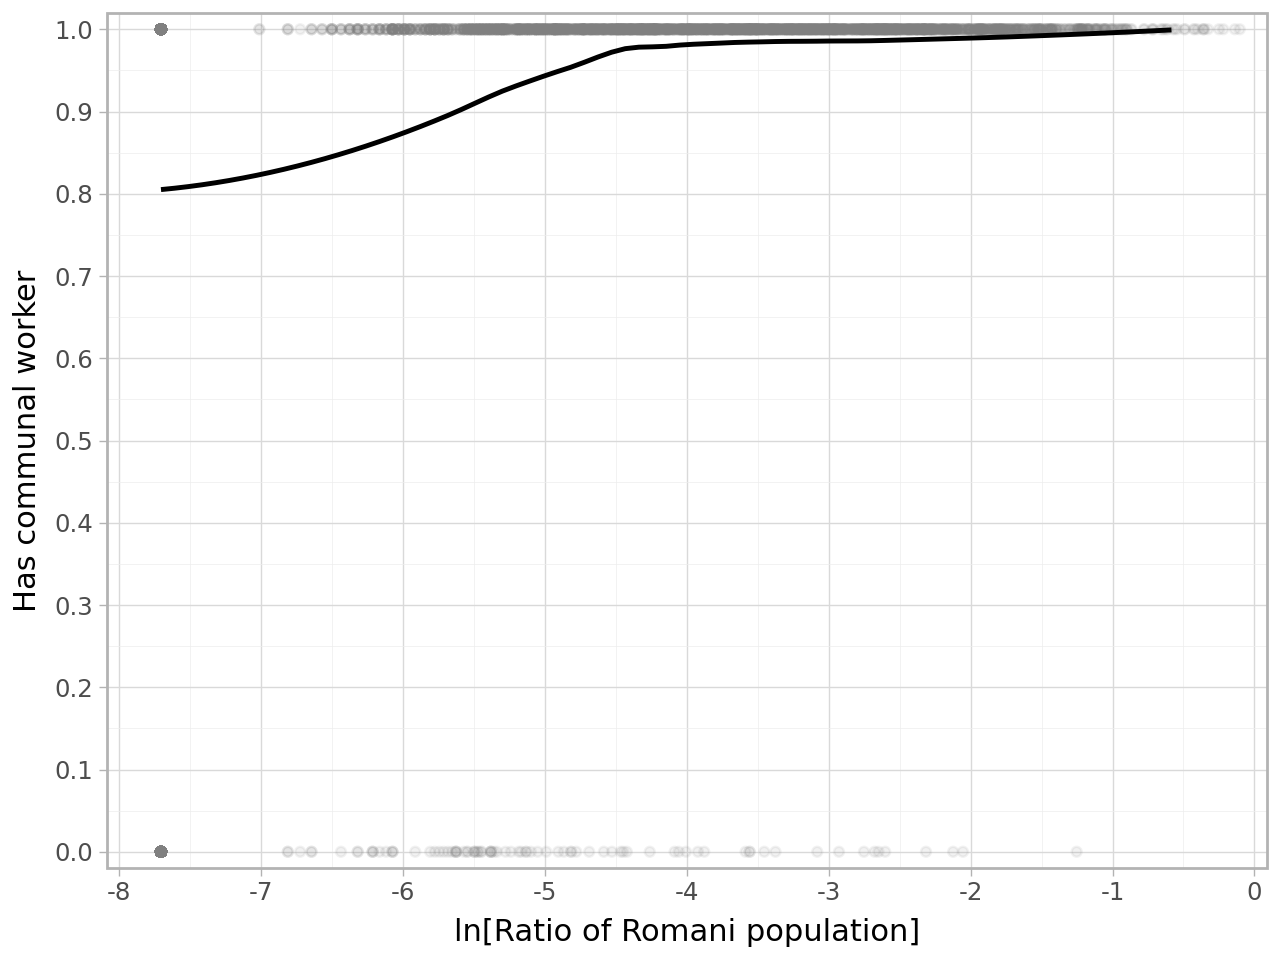

In [63]:
(
    ggplot(tidy)
    + aes(x = 'ln_romani_ratio', y = 'has_comm_worker')
    + geom_point(color = 'grey', alpha = 0.1)
    + geom_smooth(method = 'loess', se = False, span = 0.5)
    + theme_light()
    + scale_x_continuous(expand=(0.01, 0.01),
                         limits=(-8, 0),
                         breaks=np.arange(-8,1,1)
                        )
    + scale_y_continuous(expand=(0.01, 0.01),
                         limits = (0,1),
                         breaks=np.arange(0,1.1,0.1)
                        )
    + labs(x = 'ln[Ratio of Romani population]', y = 'Has communal worker')
)

For the regular set-up (with municipalities with no communal workers omitted), we can see a linear relationship if ln_romani_ratio is larger than -6. All in all, the relationship seems rather quadratic.

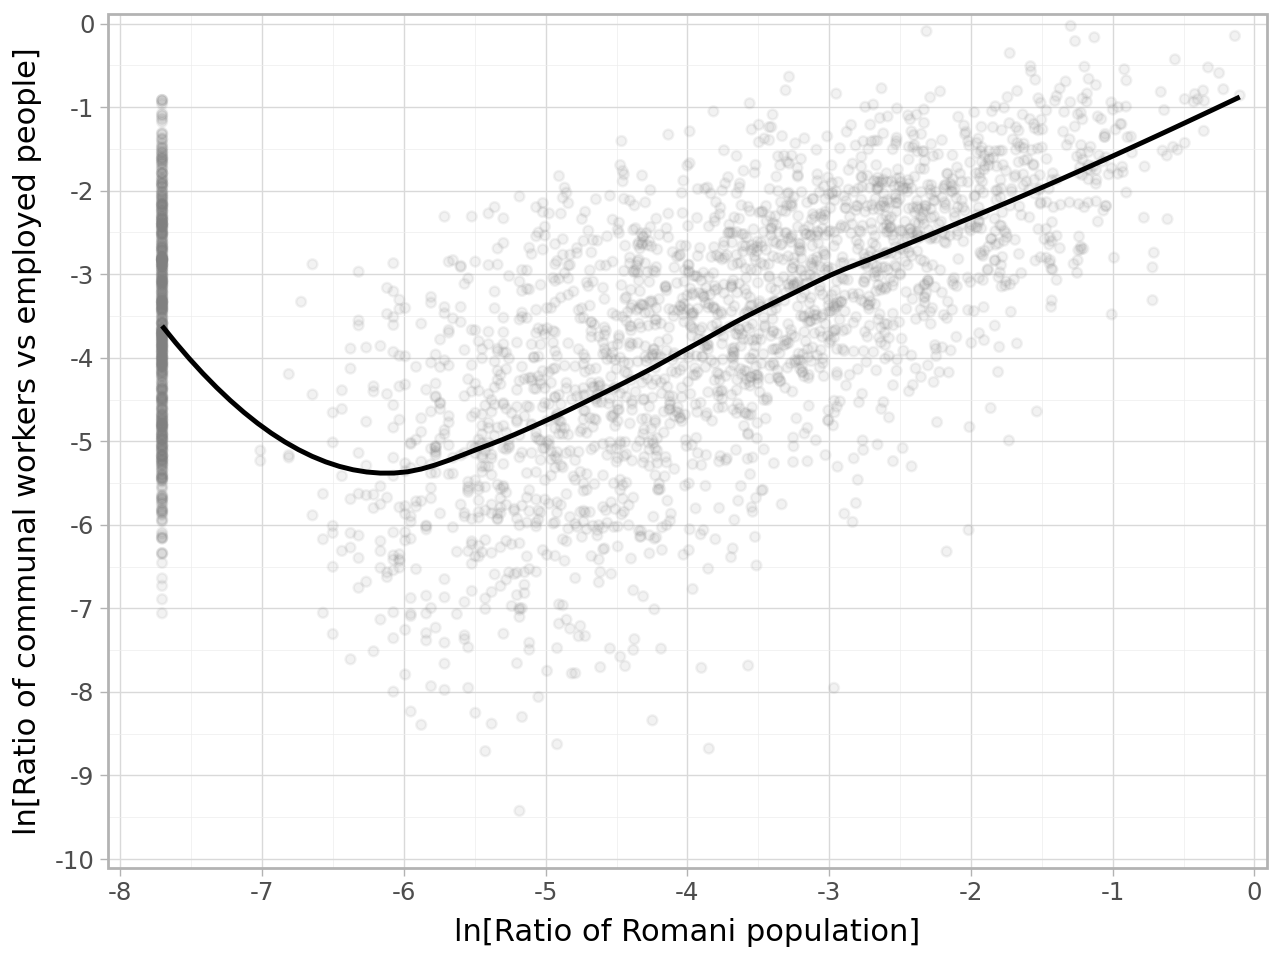

In [66]:
(
    ggplot(tidy[tidy['has_comm_worker'] == 1])
    + aes(x = 'ln_romani_ratio', y = 'ln_comm_work_per_employed')
    + geom_point(color = 'grey', alpha = 0.1)
    + geom_smooth(method = 'loess', se = False, span = 0.5)
    + theme_light()
    + scale_x_continuous(expand=(0.01, 0.01),
                         limits=(-8, 0),
                         breaks=np.arange(-8,1,1)
                        )
    + scale_y_continuous(expand=(0.01, 0.01),
                         limits = (-10,0),
                         breaks=np.arange(-10,1,1)
                        )
    + labs(x = 'ln[Ratio of Romani population]', y = 'ln[Ratio of communal workers vs employed people]')
)

Modelling

Probability models for the whole sample, where we predict the probability of the municipality having communal workers

In [249]:
train, test = train_test_split(
    tidy, test_size=0.2, random_state=42)

In [251]:
test.head()

,muni_id,muni_name,status,is_county_center,county,district,comm_work_per_employed,romani_ratio,monthly_income_pc,unemp_ratio,...,romani_zero_flag,ln_comm_work_per_employed,has_comm_worker,ln_monthly_income_pc,ln_pop_density,ln_old_age_dependency_ratio,ln_gen_dependency_ratio,ln_avg_gp_visits_pc,ln_pop,ln_area
3145,1686,Zsebeháza,község,0,Győr-Moson-Sopron,Csornai,0.016393,0.0000,176999.472039,0.0000,...,1,-4.110874,1,12.083902,3.487013,-1.051210,-0.380529,0.845416,5.023881,1.536867
1842,2217,Nagykutas,község,0,Zala,Zalaegerszegi,0.018265,0.0089,169860.862579,1.0000,...,0,-4.002777,1,12.042735,4.024929,-1.397855,-0.644738,0.627622,6.159095,2.134166
2361,2369,Sárbogárd,város,0,Fejér,Sárbogárdi,0.013653,0.0098,183251.705917,0.5764,...,0,-4.293791,1,12.118616,4.141894,-1.364872,-0.627547,0.916475,9.385386,5.243492
2604,1586,Szentlőrinc,város,0,Baranya,Szentlőrinci,0.014735,0.0240,167351.898496,0.6230,...,0,-4.217545,1,12.027854,5.416540,-1.235155,-0.616001,0.794971,8.741935,3.325396
3001,1665,Vászoly,község,0,Veszprém,Balatonfüredi,0.008264,0.0000,167397.391379,0.3333,...,1,-4.795791,1,12.028126,3.525120,-1.235669,-0.512661,0.689693,5.669881,2.144761


The first modell is a simple regression, so the only explanatory variable is romani_ratio. The explanatory power of the modell is quite week, the R squared is 0.015. Based on the intercept: if romani_ratio is zero in a municipality, then we expect to have comm_worker with 91%. Municipalities with one percentage point more romani_ratio are on average 0.38 %point more likely to have comm_workers. We can already see the disadvantage of using linear probability mode, it gets outside of the 0-1 range. The next model will be a probit model.

In [253]:
simple = smf.ols("has_comm_worker ~ romani_ratio", 
               data=train).fit(cov_type ="HC1")
print(simple.summary())

                            OLS Regression Results                            
Dep. Variable:        has_comm_worker   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     85.38
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           5.08e-20
Time:                        09:45:56   Log-Likelihood:                -162.36
No. Observations:                2522   AIC:                             328.7
Df Residuals:                    2520   BIC:                             340.4
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9100      0.006    142.089   

In [254]:
train["pred_simple"] = simple.predict()

In [256]:
train["weight"] = train.groupby(["romani_ratio","has_comm_worker"])["muni_name"].transform("count")
train["weight_2"] = train["weight"] / 1000

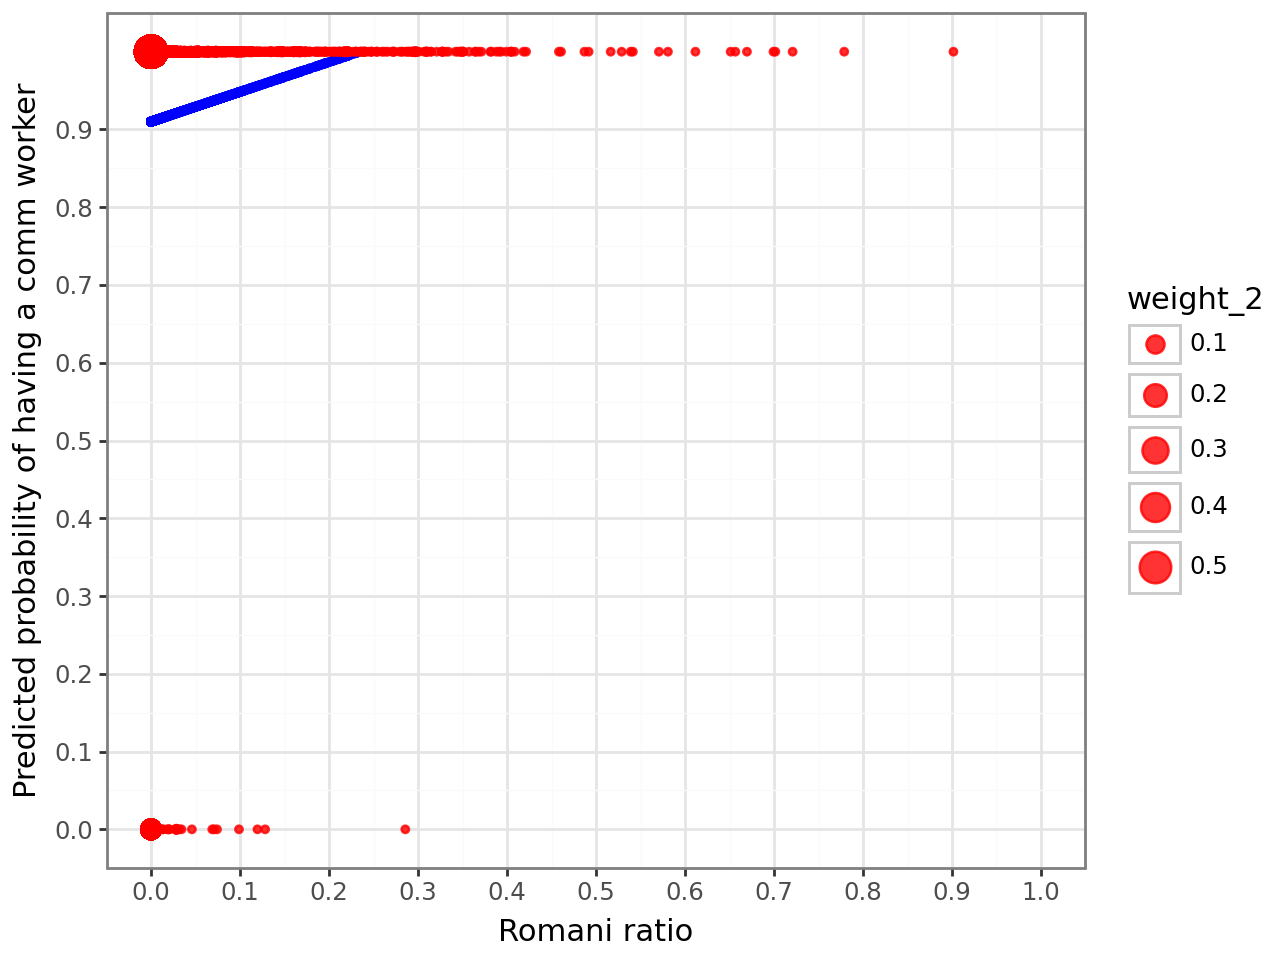

In [257]:
(
    ggplot(train)
    + geom_point(aes(x="romani_ratio", y="pred_simple"), size=1, color="blue")
    + geom_line(aes(x="romani_ratio", y="pred_simple"), colour="blue", size=0.7)
    + geom_point(
        aes(x="romani_ratio", y="has_comm_worker", size="weight_2"),
        fill="red",
        color="red",
        alpha=0.8,
        na_rm=True,
    )
    + scale_size_continuous()
    + labs(x="Romani ratio", y="Predicted probability of having a comm worker")
    + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
    + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1, 0.1))
    + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)

Logit model - simple regression

In [259]:
logit = smf.logit("has_comm_worker ~ romani_ratio", train).fit()
table = Stargazer([logit])
table

Optimization terminated successfully.
         Current function value: 0.237838
         Iterations 10


In [260]:
logit.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:        has_comm_worker
Method:                          dydx
At:                           overall
================================================================================
                  dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
romani_ratio     2.6274      0.422      6.228      0.000       1.801       3.454
================================================================================
"""

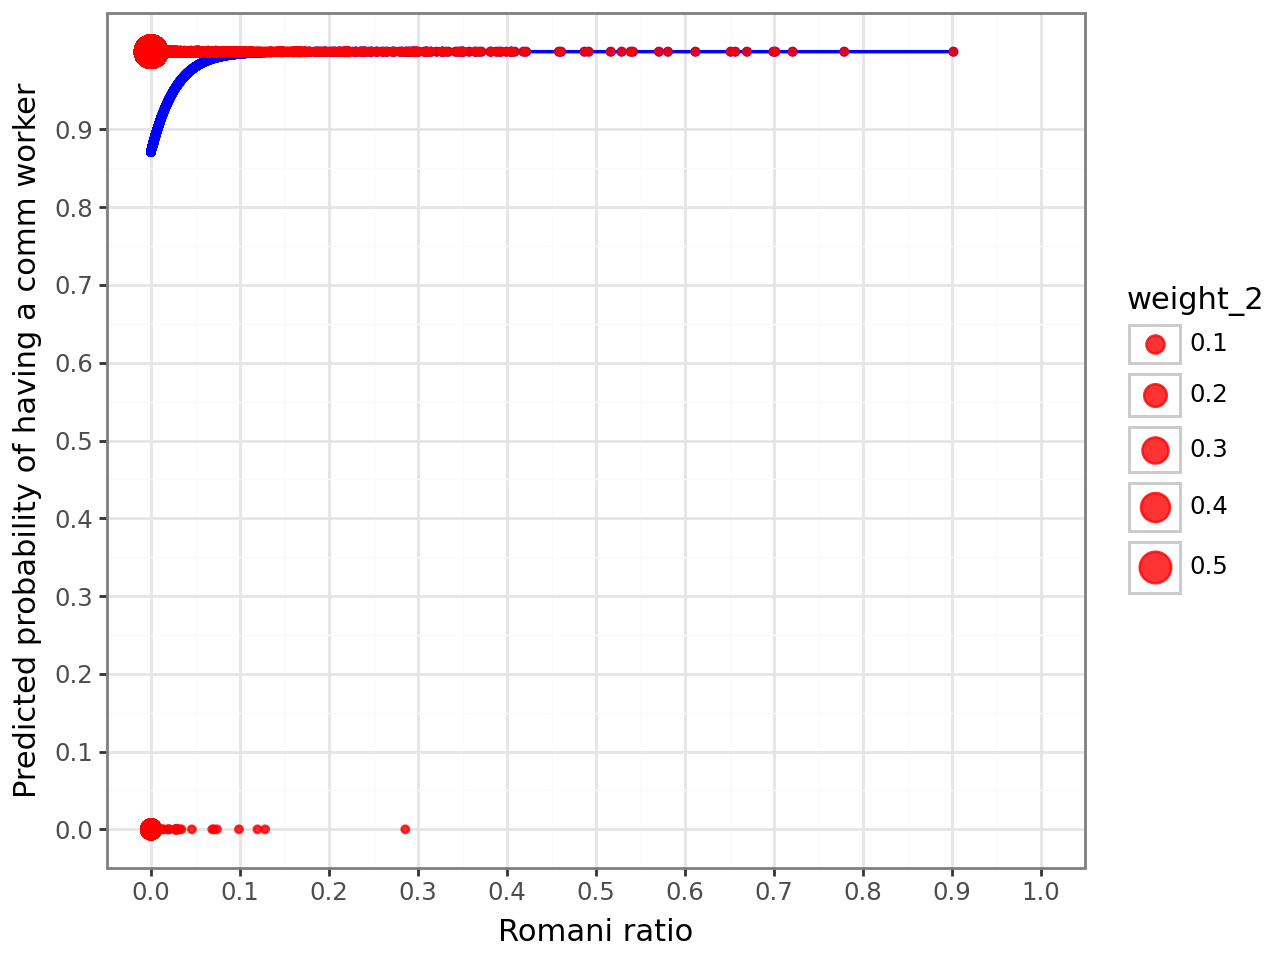

In [263]:
train["pred_logit"] = logit.predict()
train["weight"] = train.groupby(["romani_ratio","has_comm_worker"])["muni_name"].transform("count")
train["weight_2"] = train["weight"] / 1000

(
    ggplot(train)
    + geom_point(aes(x="romani_ratio", y="pred_logit"), size=1, color="blue")
    + geom_line(aes(x="romani_ratio", y="pred_logit"), colour="blue", size=0.7)
    + geom_point(
        aes(x="romani_ratio", y="has_comm_worker", size="weight_2"),
        fill="red",
        color="red",
        alpha=0.8,
        na_rm=True,
    )
    + scale_size_continuous()
    + labs(x="Romani ratio", y="Predicted probability of having a comm worker")
    + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
    + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1, 0.1))
    + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)

Simple linear probability model - level-log

In [266]:
lev_log = smf.ols("has_comm_worker ~ ln_romani_ratio+romani_zero_flag", 
               data=train).fit(cov_type ="HC1")
print(lev_log.summary())

                            OLS Regression Results                            
Dep. Variable:        has_comm_worker   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     74.24
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           4.73e-32
Time:                        09:46:05   Log-Likelihood:                -78.614
No. Observations:                2522   AIC:                             163.2
Df Residuals:                    2519   BIC:                             180.7
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.0369      0.011  

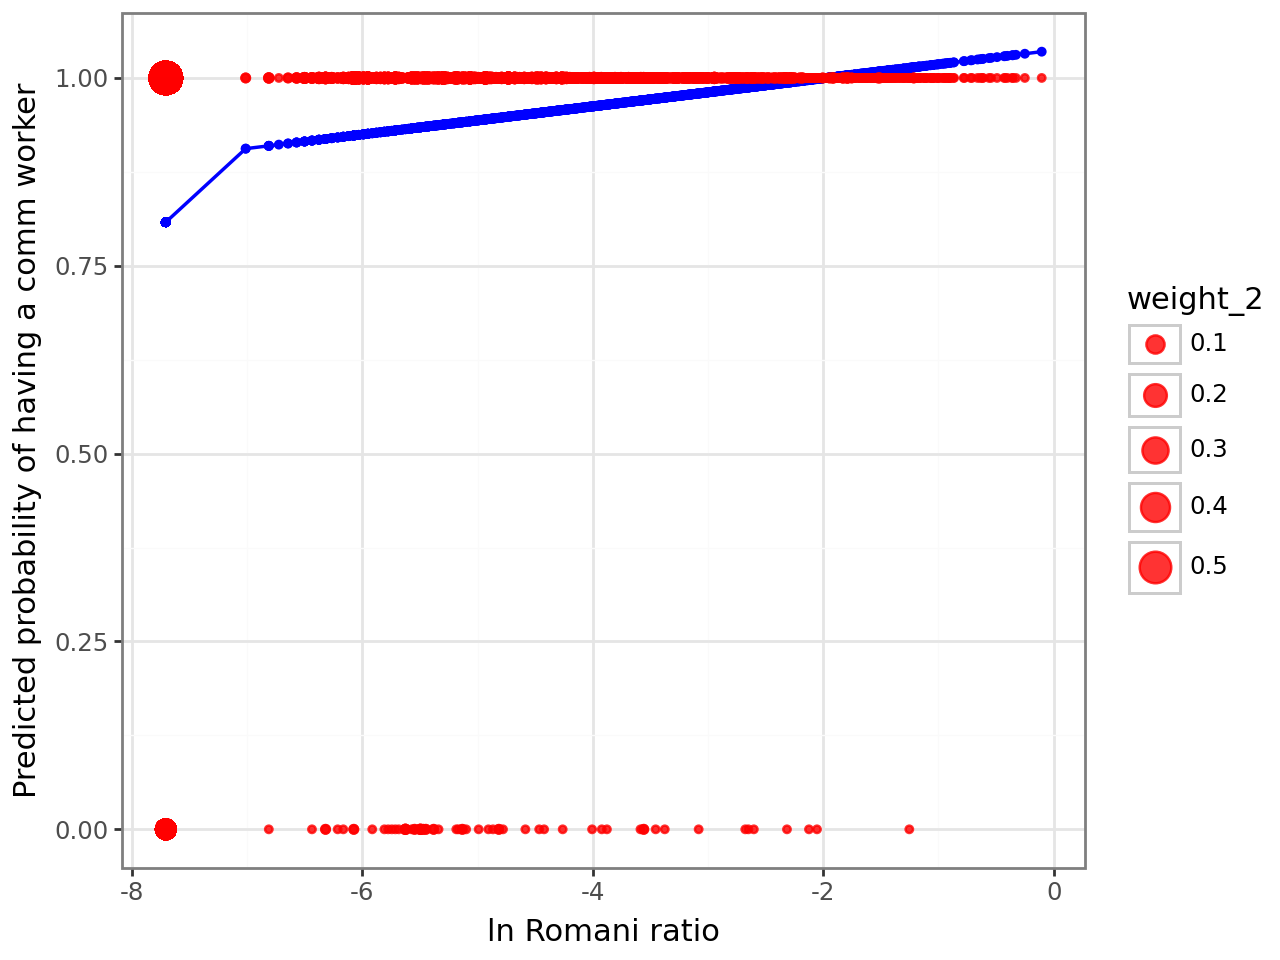

In [418]:
train["pred_lev_log"] = lev_log.predict()
train["weight"] = train.groupby(["ln_romani_ratio","has_comm_worker"])["muni_name"].transform("count")
train["weight_2"] = train["weight"] / 1000

(
    ggplot(train)
    + geom_point(aes(x="ln_romani_ratio", y="pred_lev_log"), size=1, color="blue")
    + geom_line(aes(x="ln_romani_ratio", y="pred_lev_log"), colour="blue", size=0.7)
    + geom_point(
        aes(x="ln_romani_ratio", y="has_comm_worker", size="weight_2"),
        fill="red",
        color="red",
        alpha=0.8,
        na_rm=True,
    )
    + scale_size_continuous()
    + labs(x="ln Romani ratio", y="Predicted probability of having a comm worker")
    #+ coord_cartesian(xlim=(0, 1), ylim=(0, 1))
    #+ scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1, 0.1))
    #+ scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)

ugyanez logitra

Simple - linear probability model - spline

In [269]:
import copy
def lspline(series, knots):
    def knot_ceil(vector, knot):
        vector_copy = copy.deepcopy(vector)
        vector_copy[vector_copy > knot] = knot
        return vector_copy

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix

In [422]:
spline = smf.ols(
    "has_comm_worker ~ lspline(ln_romani_ratio,[-4.5])", train).fit(covtype="HC3")
print(spline.summary())

                            OLS Regression Results                            
Dep. Variable:        has_comm_worker   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     111.9
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           2.80e-47
Time:                        15:22:09   Log-Likelihood:                -74.577
No. Observations:                2522   AIC:                             155.2
Df Residuals:                    2519   BIC:                             172.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

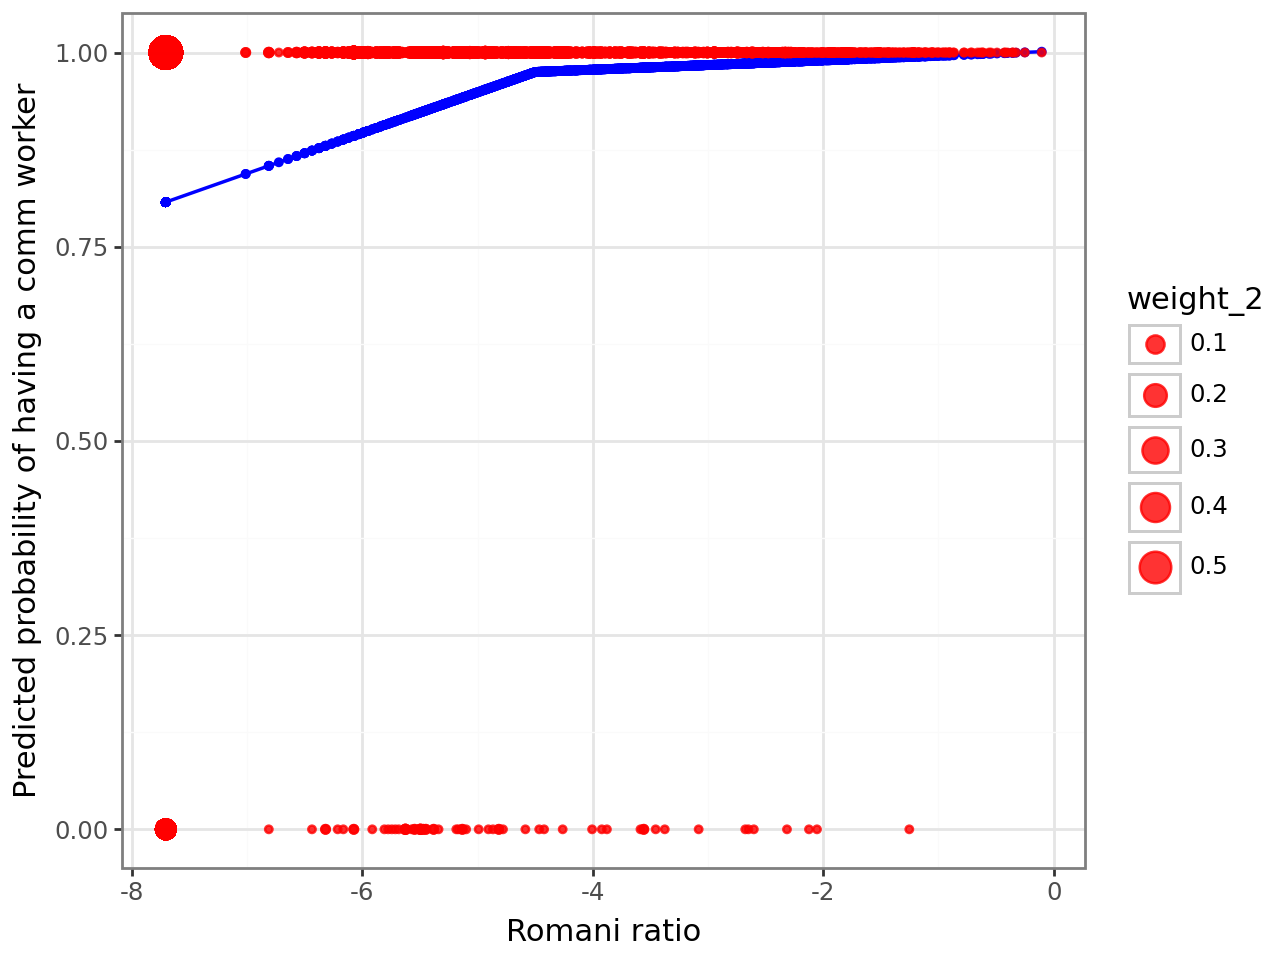

In [426]:
train["pred_spline"] = spline.predict()
train["weight"] = train.groupby(["ln_romani_ratio","has_comm_worker"])["muni_name"].transform("count")
train["weight_2"] = train["weight"] / 1000

(
    ggplot(train)
    + geom_point(aes(x="ln_romani_ratio", y="pred_spline"), size=1, color="blue")
    + geom_line(aes(x="ln_romani_ratio", y="pred_spline"), colour="blue", size=0.7)
    + geom_point(
        aes(x="ln_romani_ratio", y="has_comm_worker", size="weight_2"),
        fill="red",
        color="red",
        alpha=0.8,
        na_rm=True,
    )
    + scale_size_continuous()
    + labs(x="Romani ratio", y="Predicted probability of having a comm worker")
    #+ coord_cartesian(xlim=(0, 1), ylim=(0, 1))
    #+ scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1, 0.1))
    #+ scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)


Ebből logitot

Marginalt valahogy belerakni az összehasonlításba

In [428]:
table = Stargazer([simple,logit, lev_log, spline ])
table

Relationship of having a comm worker and the explanatory variables

In [275]:
pd.crosstab(index = train['has_comm_worker'],columns= train['is_county_center'])

is_county_center,0,1
has_comm_worker,,
0,184,0
1,2327,11


harmadfokú vagy log és valami

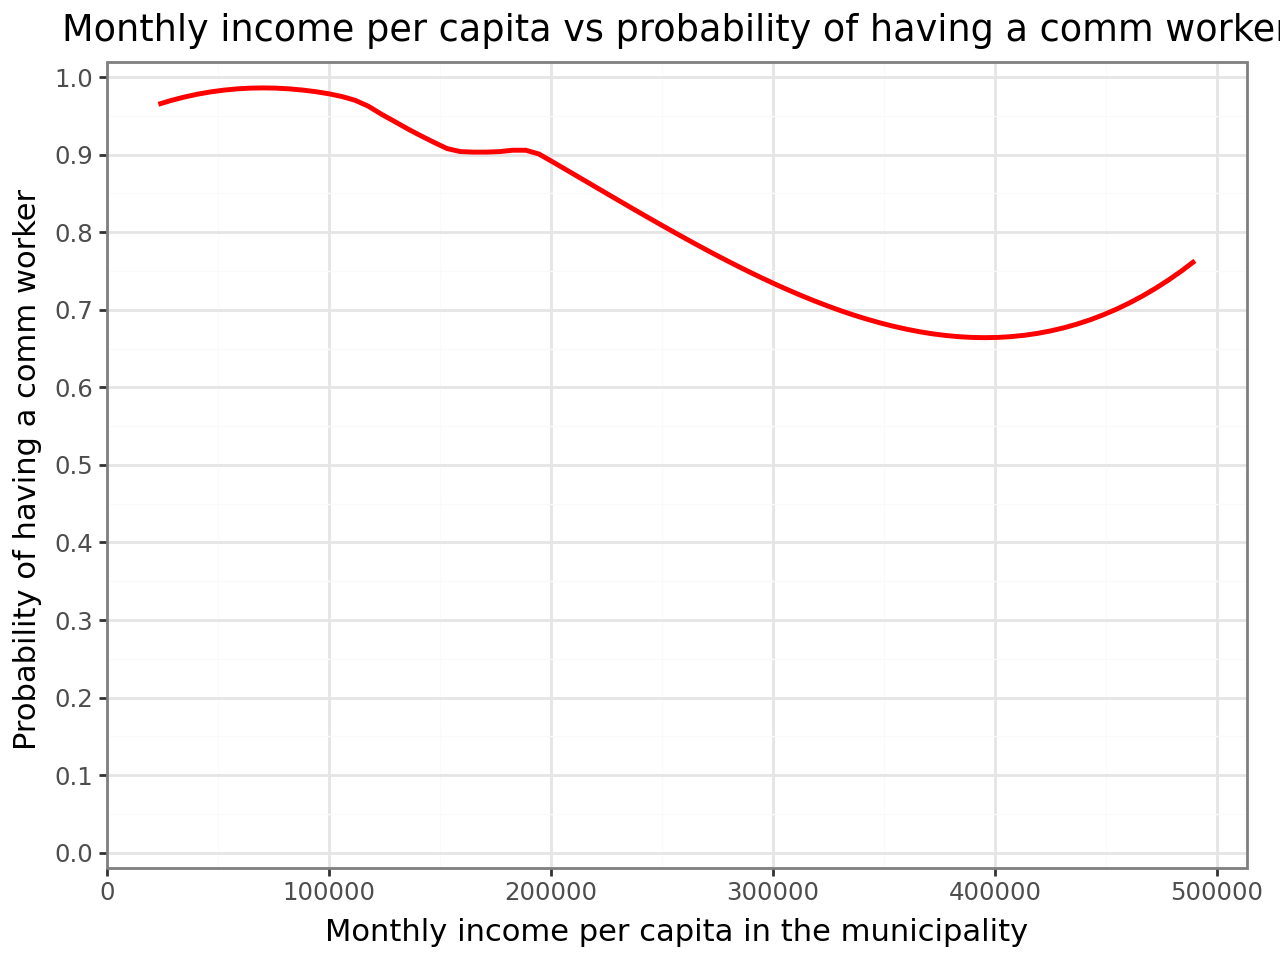

In [440]:
(
    ggplot(data=train)
    + geom_smooth(
        aes(x="monthly_income_pc", y="has_comm_worker"), method="loess", se=False, color="red"
    )
    + labs(
        x="Monthly income per capita in the municipality", y="Probability of having a comm worker ", title="Monthly income per capita vs probability of having a comm worker"
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)

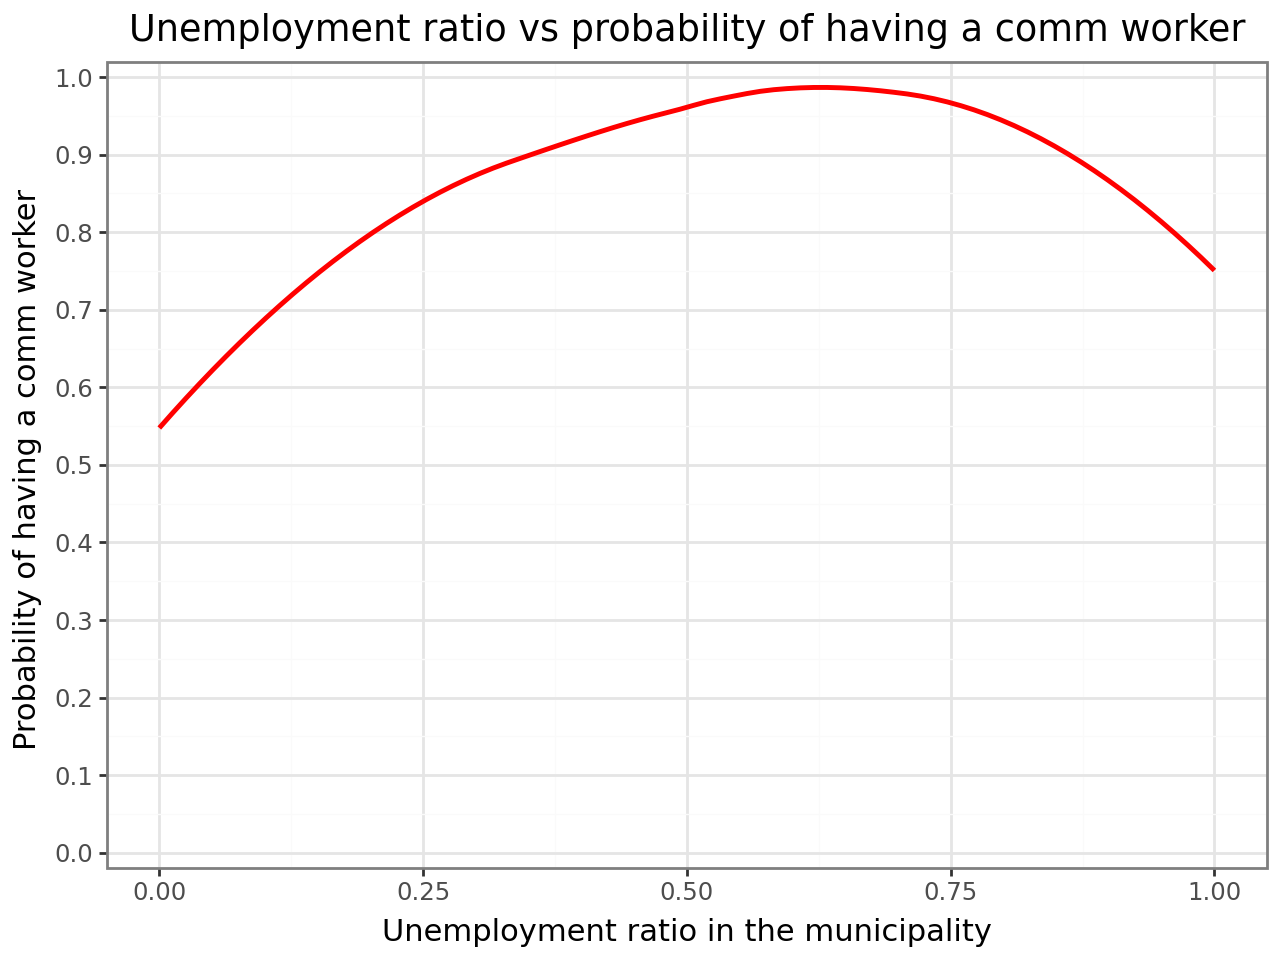

In [277]:
(
    ggplot(data=train)
    + geom_smooth(
        aes(x="unemp_ratio", y="has_comm_worker"), method="loess", se=False, color="red"
    )
    + labs(
        x="Unemployment ratio in the municipality", y="Probability of having a comm worker ", title="Unemployment ratio vs probability of having a comm worker"
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)

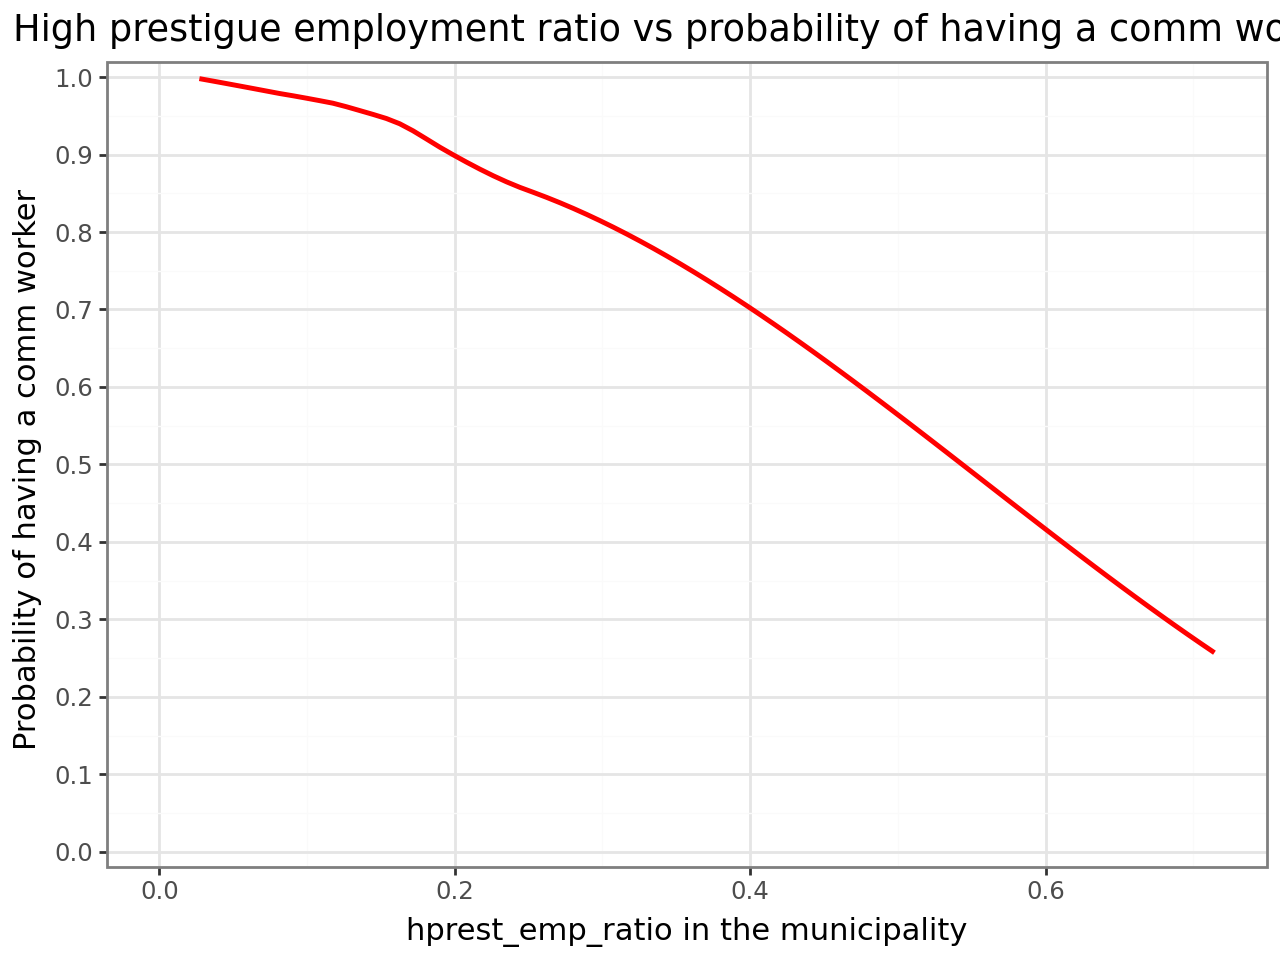

In [365]:
(
    ggplot(data=train)
    + geom_smooth(
        aes(x="hprest_emp_ratio", y="has_comm_worker"), method="loess", se=False, color="red"
    )
    + labs(
        x="hprest_emp_ratio in the municipality", y="Probability of having a comm worker ", title="High prestigue employment ratio vs probability of having a comm worker"
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)

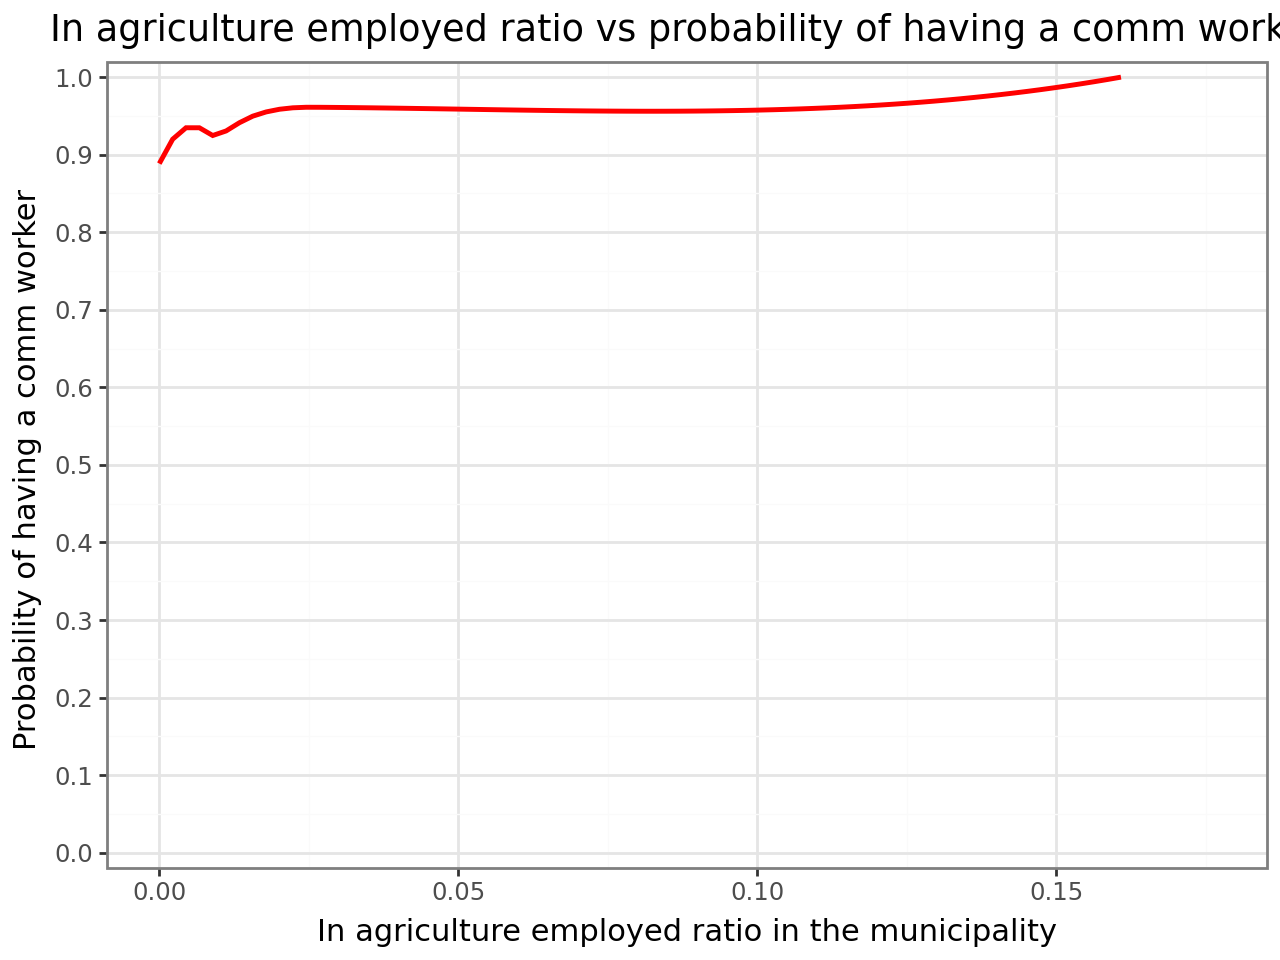

In [280]:
(
    ggplot(data=train)
    + geom_smooth(
        aes(x="agr_emp_ratio", y="has_comm_worker"), method="loess", se=False, color="red"
    )
    + labs(
        x="In agriculture employed ratio in the municipality", y="Probability of having a comm worker ", title="In agriculture employed ratio vs probability of having a comm worker"
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)

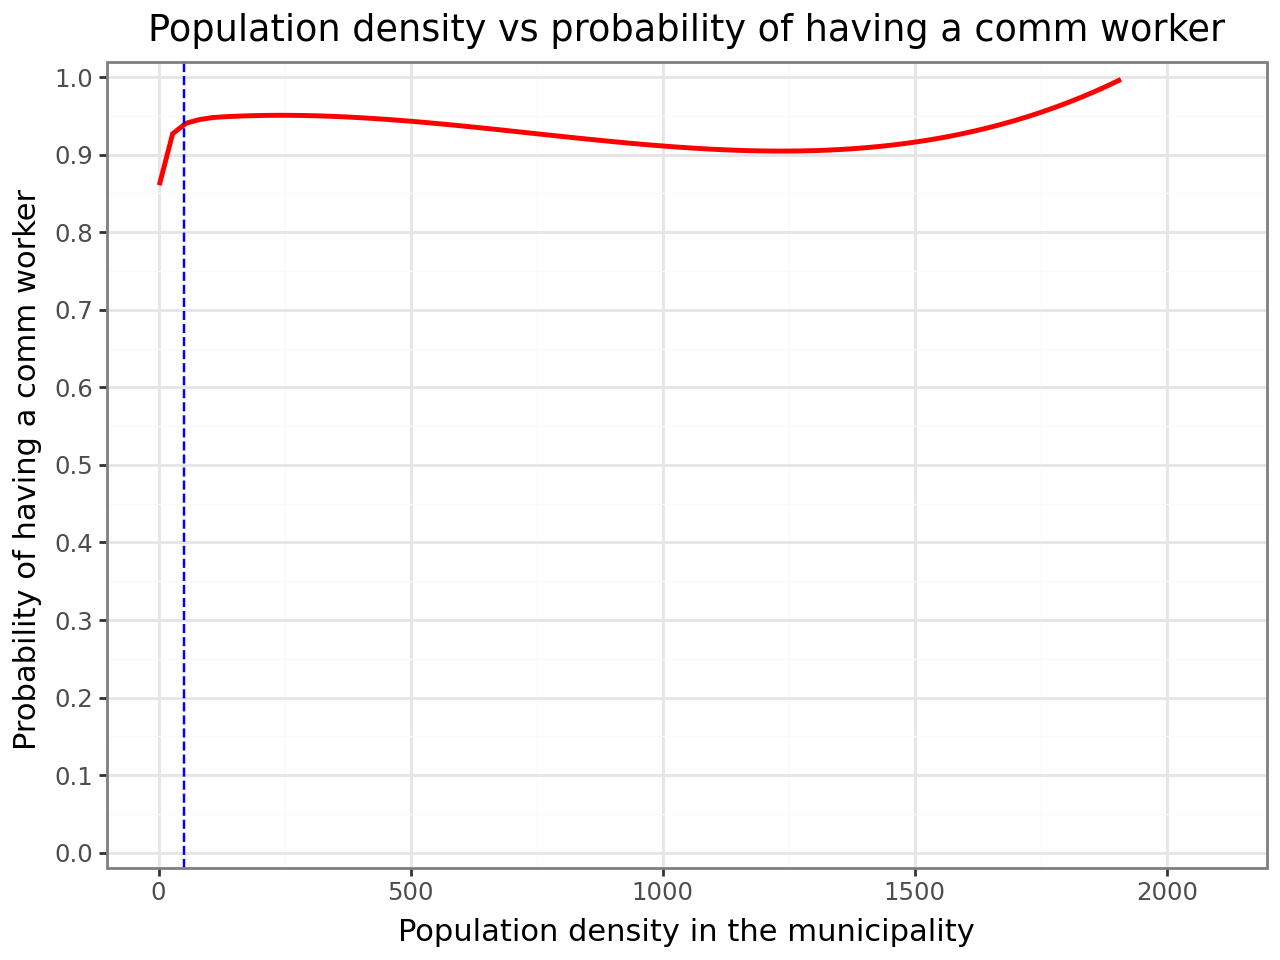

In [375]:
(
    ggplot(data=train)
    + geom_smooth(
        aes(x="pop_density", y="has_comm_worker"), method="loess", se=False, color="red"
    )
    + labs(
        x="Population density in the municipality", y="Probability of having a comm worker ", title="Population density vs probability of having a comm worker"
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
    +geom_vline(xintercept=50, color="blue", linetype="dashed")
)

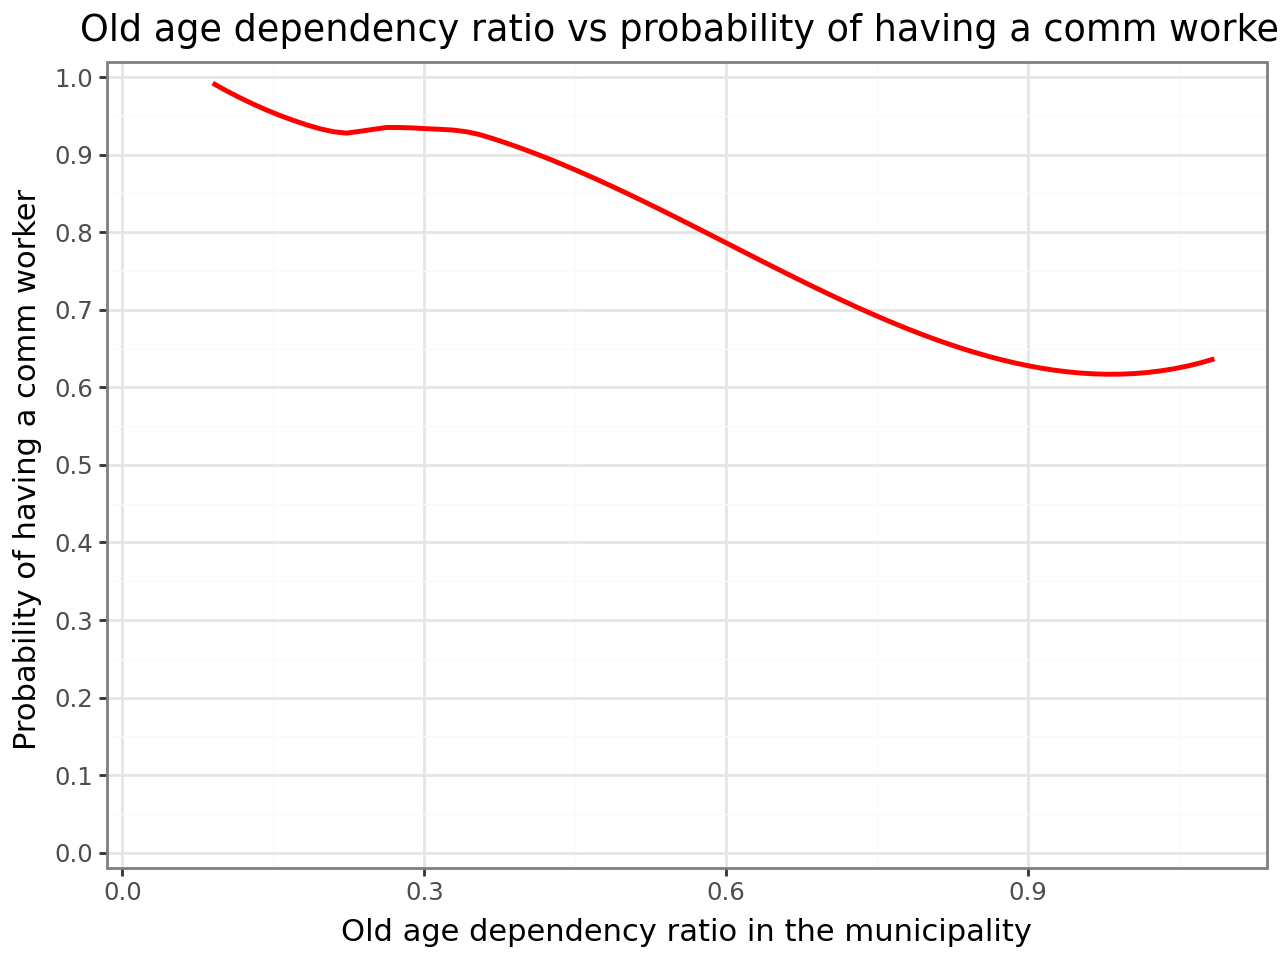

In [282]:
(
    ggplot(data=train)
    + geom_smooth(
        aes(x="old_age_dependency_ratio", y="has_comm_worker"), method="loess", se=False, color="red"
    )
    + labs(
        x="Old age dependency ratio in the municipality", y="Probability of having a comm worker ", title="Old age dependency ratio vs probability of having a comm worker"
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)

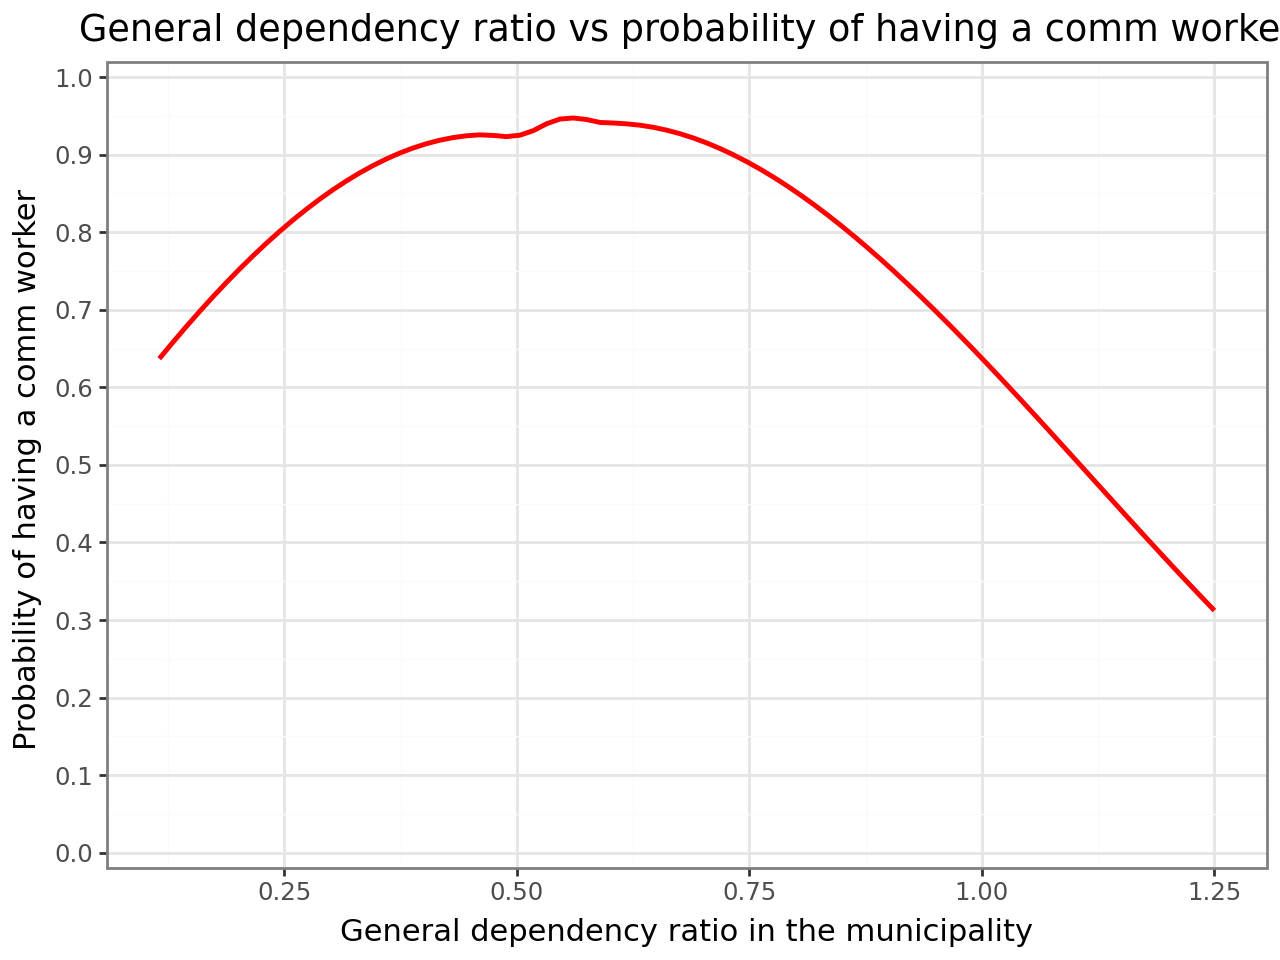

In [285]:
(
    ggplot(data=train)
    + geom_smooth(
        aes(x="gen_dependency_ratio", y="has_comm_worker"), method="loess", se=False, color="red"
    )
    + labs(
        x="General dependency ratio in the municipality", y="Probability of having a comm worker ", title="General dependency ratio vs probability of having a comm worker"
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)

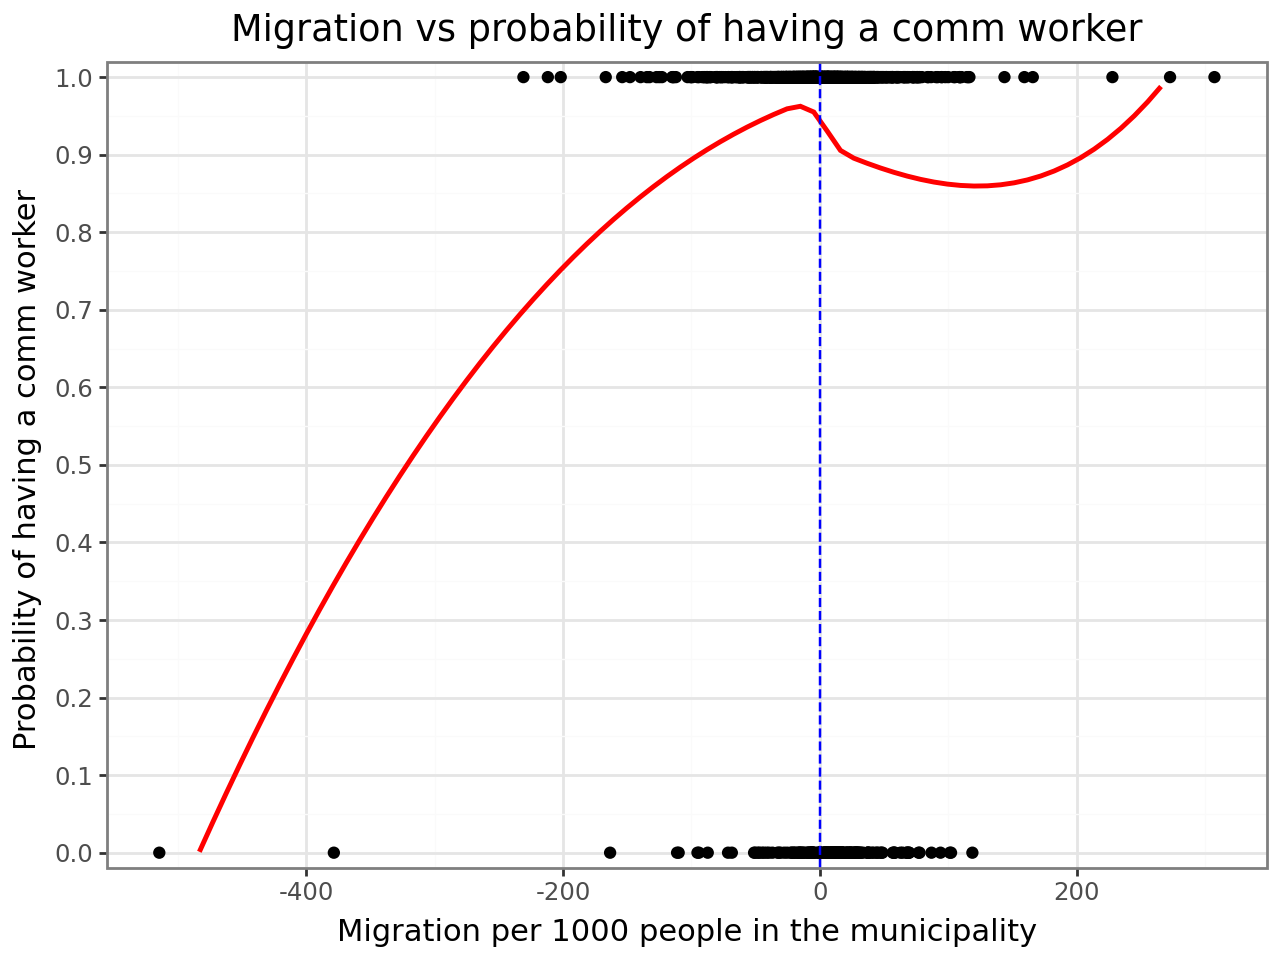

In [444]:
(
    ggplot(data=train)
    + geom_smooth(
        aes(x="migration_per1000", y="has_comm_worker"), method="loess", se=False, color="red"
    )
    +geom_point(aes(x="migration_per1000", y="has_comm_worker"))
    + labs(
        x="Migration per 1000 people in the municipality", y="Probability of having a comm worker ", title="Migration vs probability of having a comm worker"
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
    +geom_vline(xintercept=0, color="blue", linetype="dashed")
)

In [ ]:
spline, kvadratikus Marci kódja

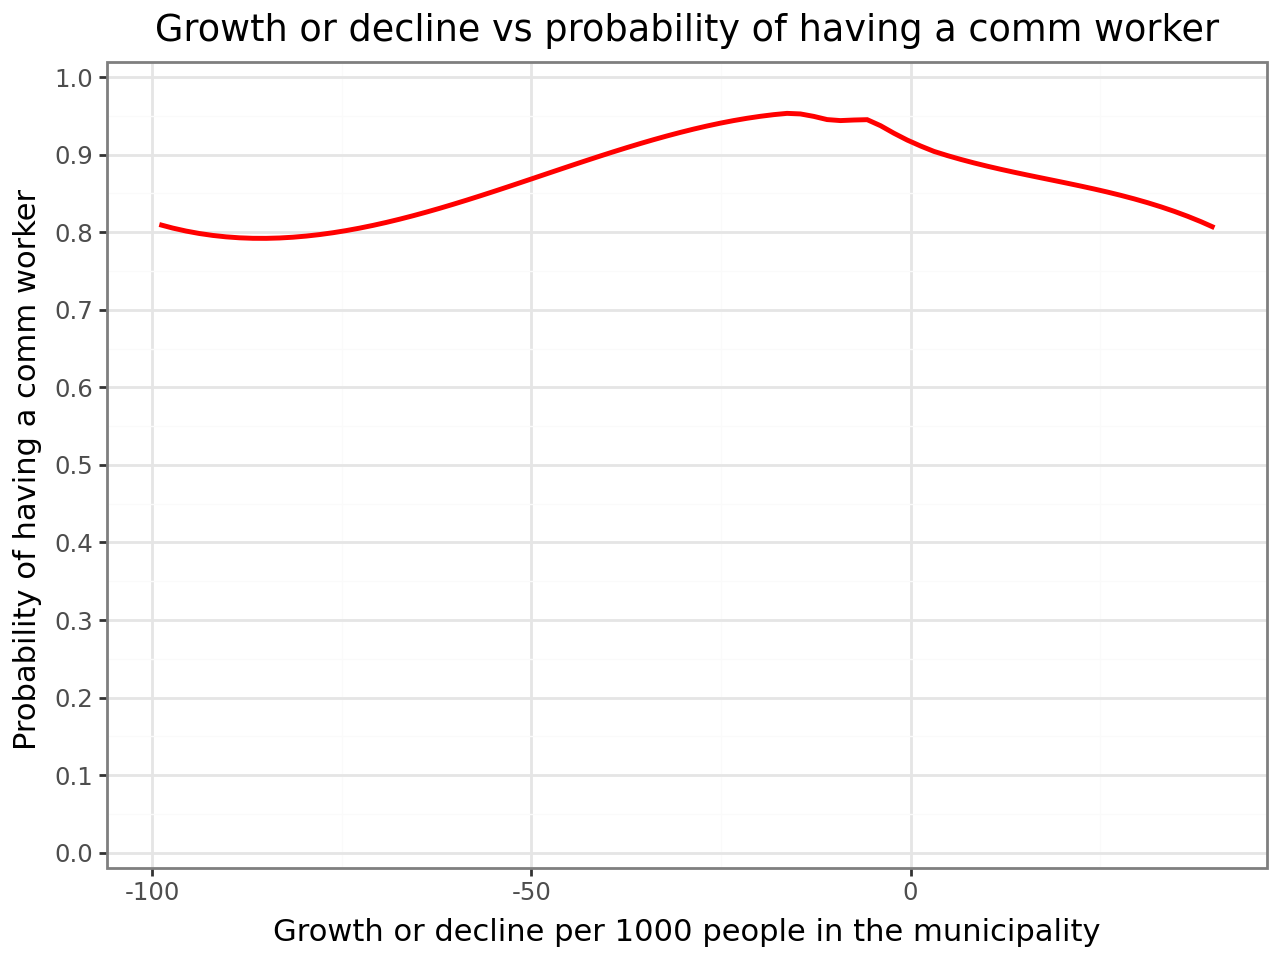

In [287]:
(
    ggplot(data=train)
    + geom_smooth(
        aes(x="growth_decline_per1000", y="has_comm_worker"), method="loess", se=False, color="red"
    )
    + labs(
        x="Growth or decline per 1000 people in the municipality", y="Probability of having a comm worker ", title="Growth or decline vs probability of having a comm worker"
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)

spline 0ra

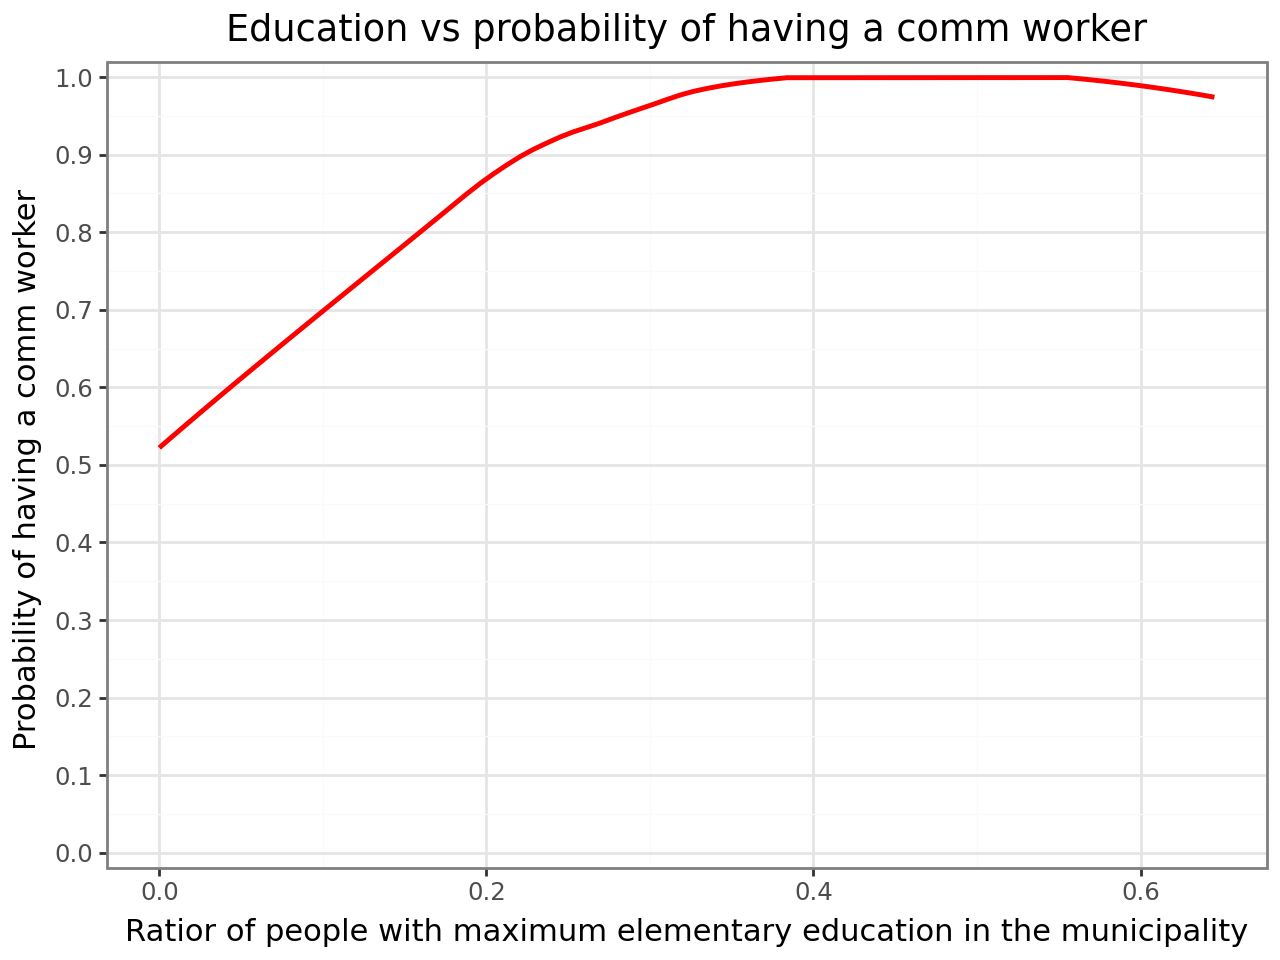

In [288]:
(
    ggplot(data=train)
    + geom_smooth(
        aes(x="max_elem_educ_ratio", y="has_comm_worker"), method="loess", se=False, color="red"
    )
    + labs(
        x="Ratior of people with maximum elementary education in the municipality", y="Probability of having a comm worker ", title="Education vs probability of having a comm worker"
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)

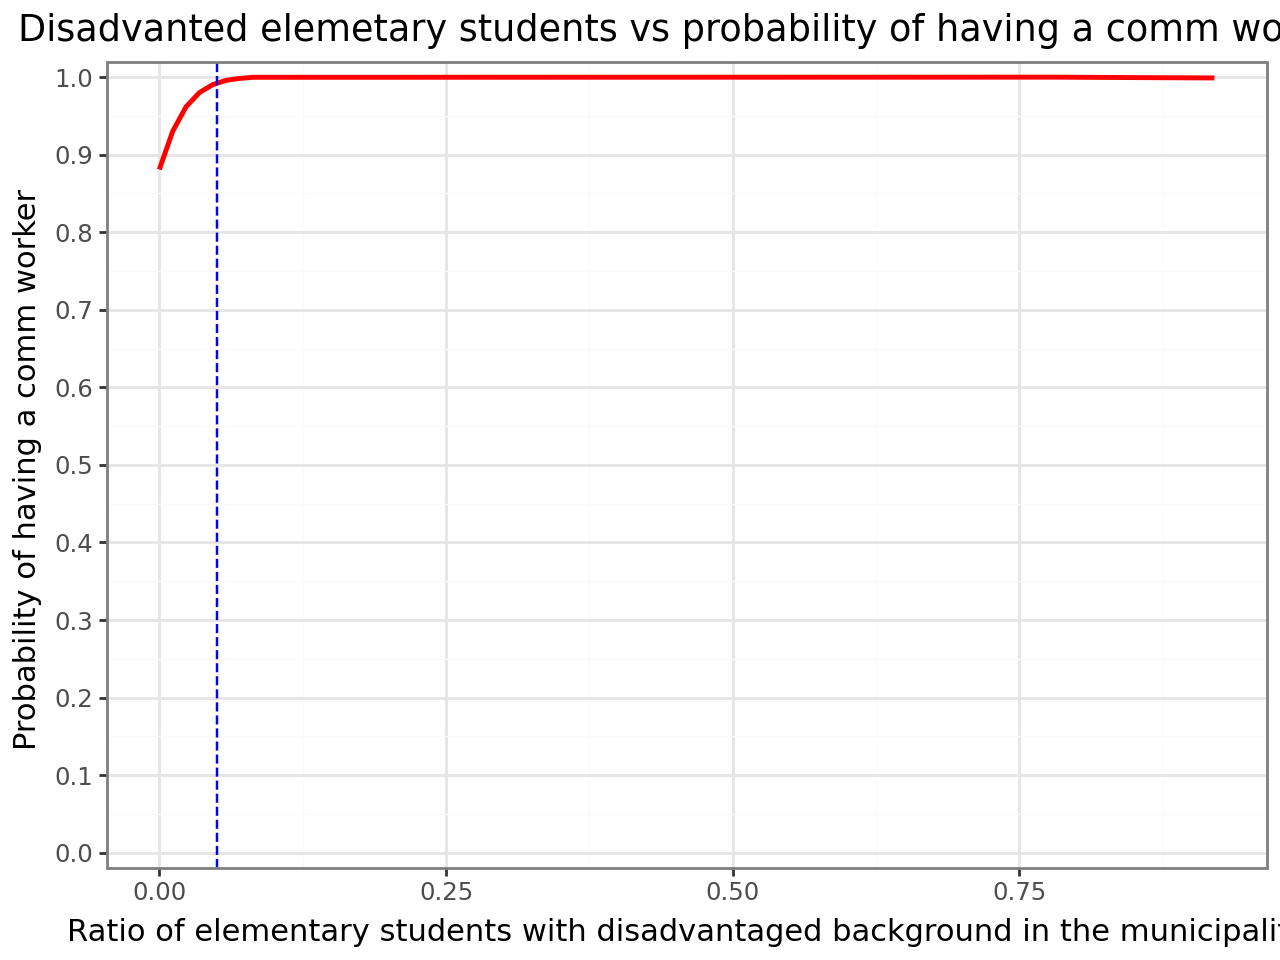

In [391]:
(
    ggplot(data=train)
    + geom_smooth(
        aes(x="disadv_elem_students_ratio", y="has_comm_worker"), method="loess", se=False, color="red"
    )
    + labs(
        x="Ratio of elementary students with disadvantaged background in the municipality", y="Probability of having a comm worker ", title="Disadvanted elemetary students vs probability of having a comm worker"
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
    +geom_vline(xintercept=0.05, color="blue", linetype="dashed")
)

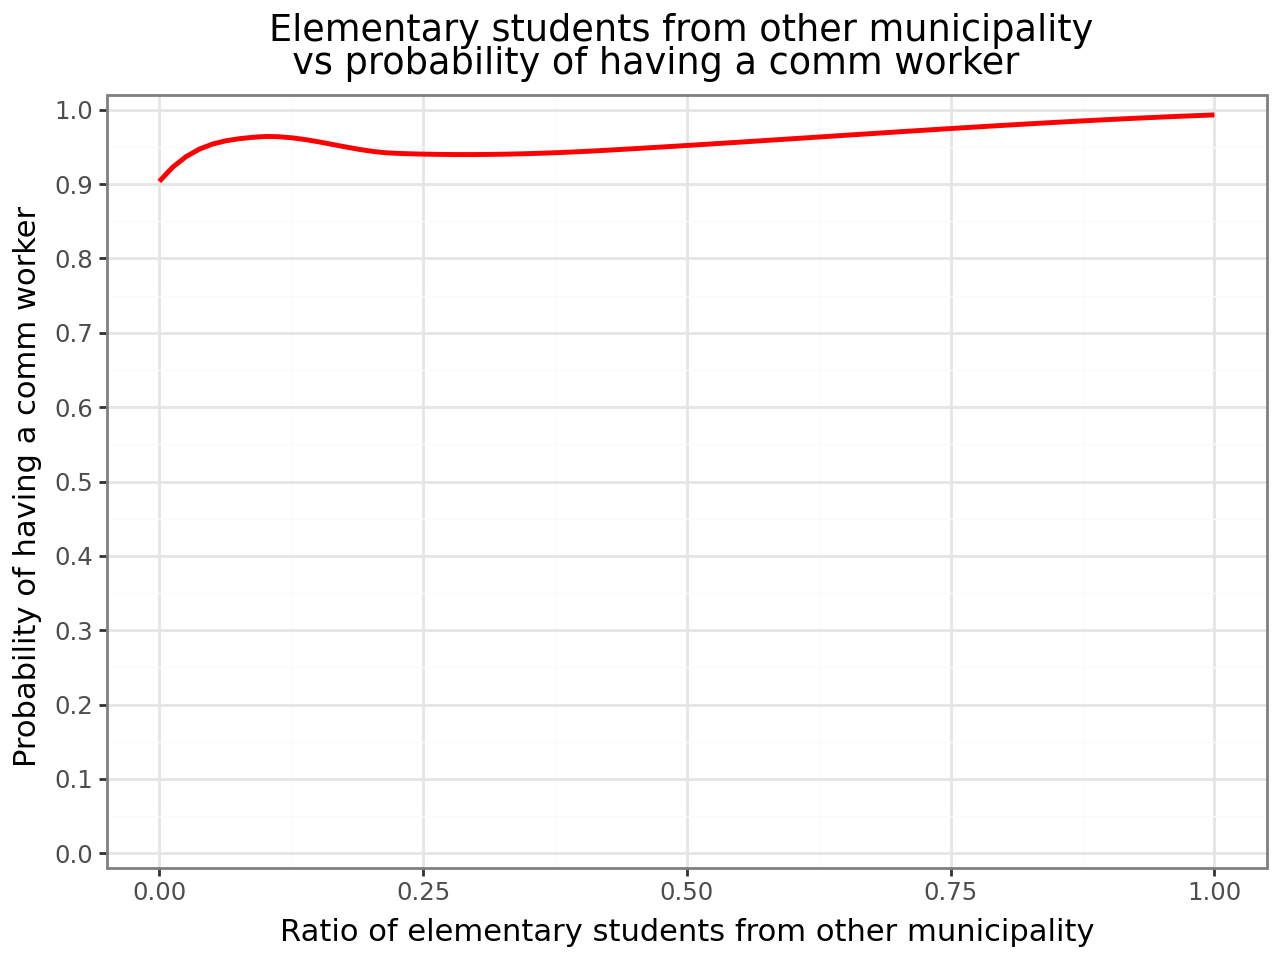

In [290]:
(
    ggplot(data=train)
    + geom_smooth(
        aes(x="elem_stud_from_other_muni_ratio", y="has_comm_worker"), method="loess", se=False, color="red"
    )
    + labs(
        x="Ratio of elementary students from other municipality", y="Probability of having a comm worker ", title="Elementary students from other municipality \n  vs probability of having a comm worker"
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)

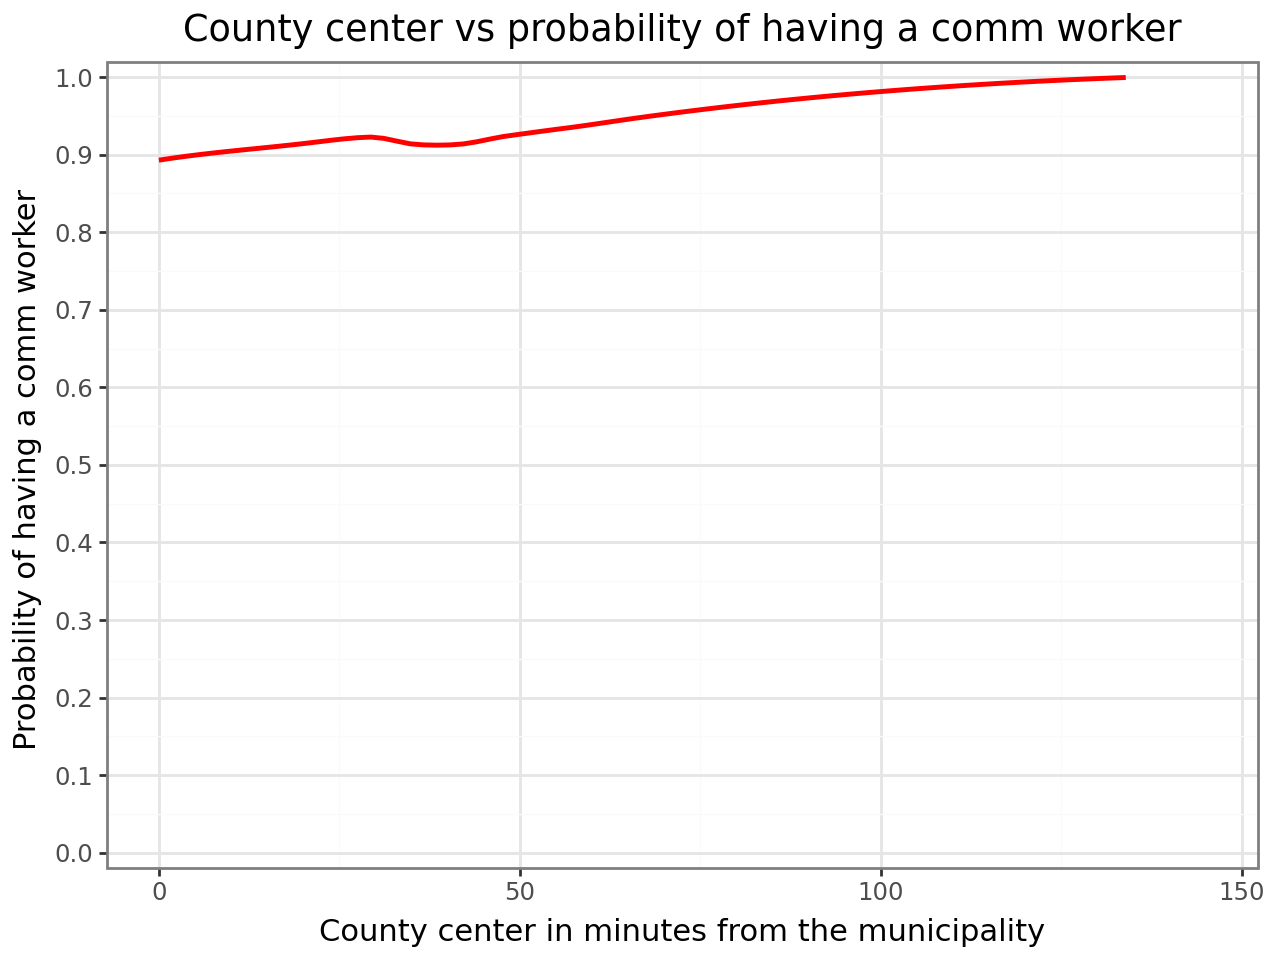

In [291]:
(
    ggplot(data=train)
    + geom_smooth(
        aes(x="county_center_min", y="has_comm_worker"), method="loess", se=False, color="red"
    )
    + labs(
        x="County center in minutes from the municipality", y="Probability of having a comm worker ", title="County center vs probability of having a comm worker"
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)

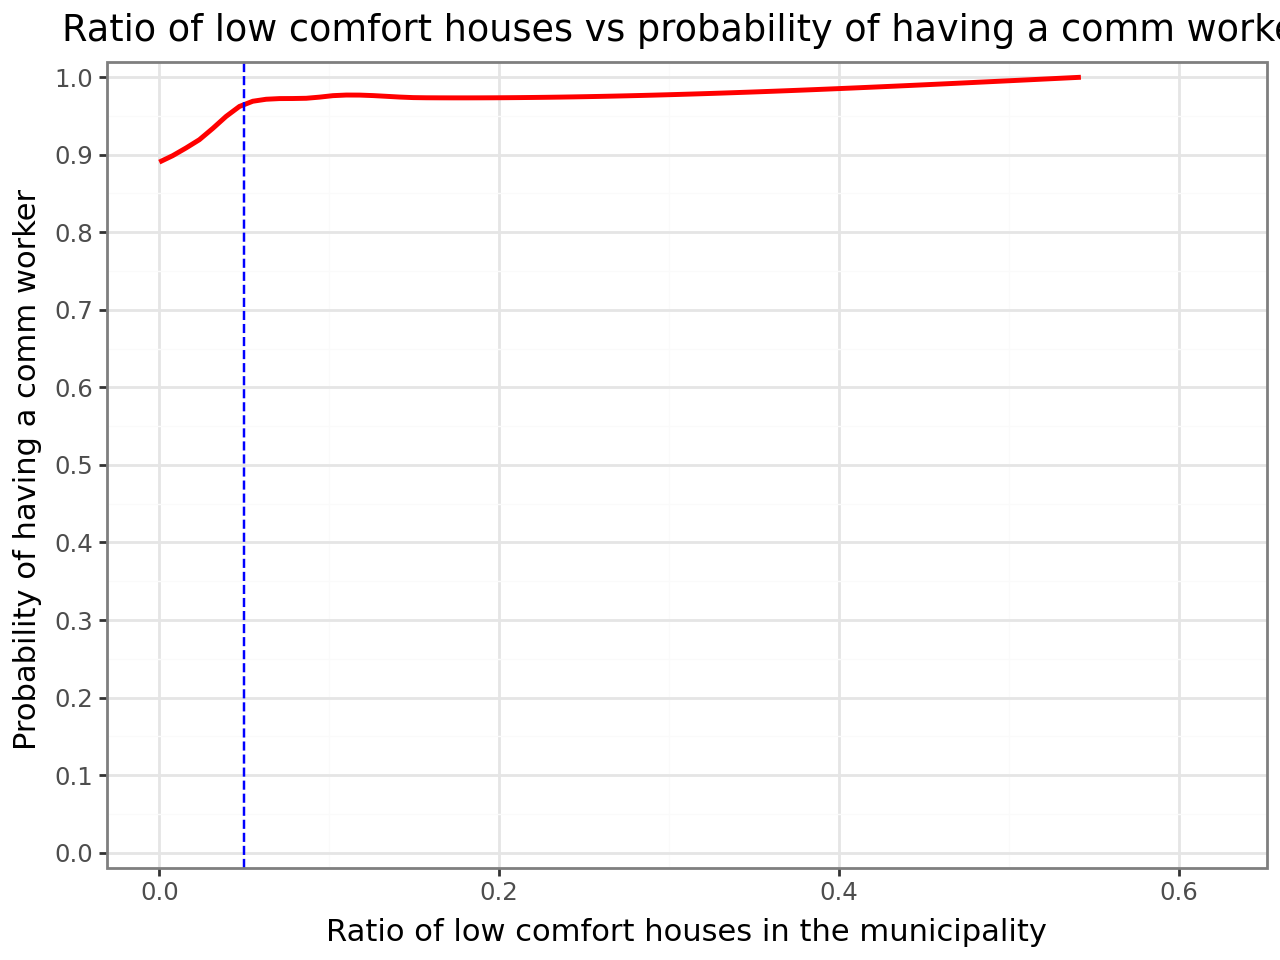

In [405]:
(
    ggplot(data=train)
    + geom_smooth(
        aes(x="low_comf_housing_ratio", y="has_comm_worker"), method="loess", se=False, color="red"
    )
    + labs(
        x="Ratio of low comfort houses in the municipality", y="Probability of having a comm worker ", title="Ratio of low comfort houses vs probability of having a comm worker"
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
    + geom_vline(xintercept=0.05, color="blue", linetype="dashed")
)

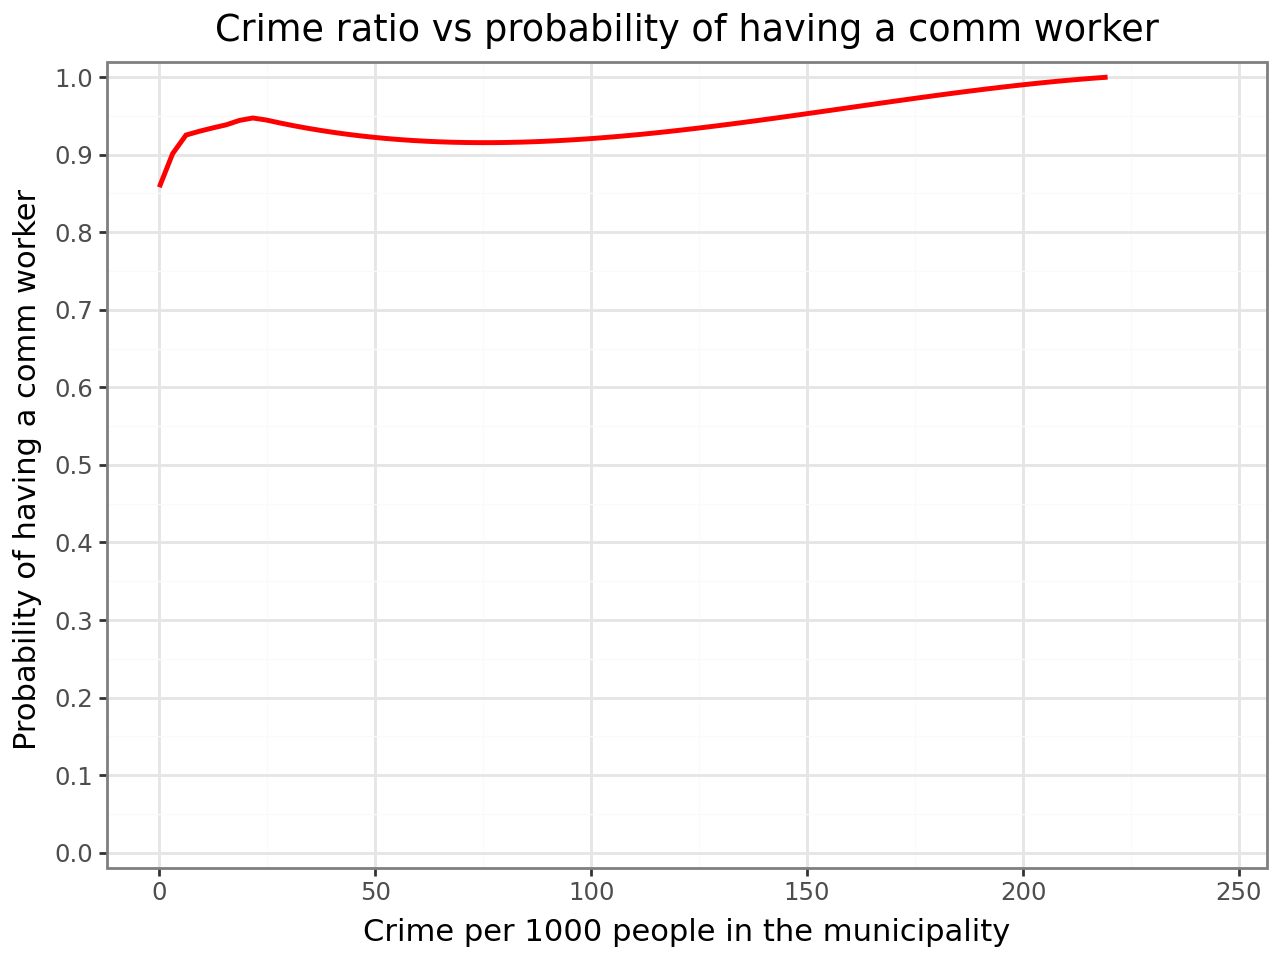

In [293]:
(
    ggplot(data=train)
    + geom_smooth(
        aes(x="crime_per1000people", y="has_comm_worker"), method="loess", se=False, color="red"
    )
    + labs(
        x="Crime per 1000 people in the municipality", y="Probability of having a comm worker ", title="Crime ratio vs probability of having a comm worker"
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)

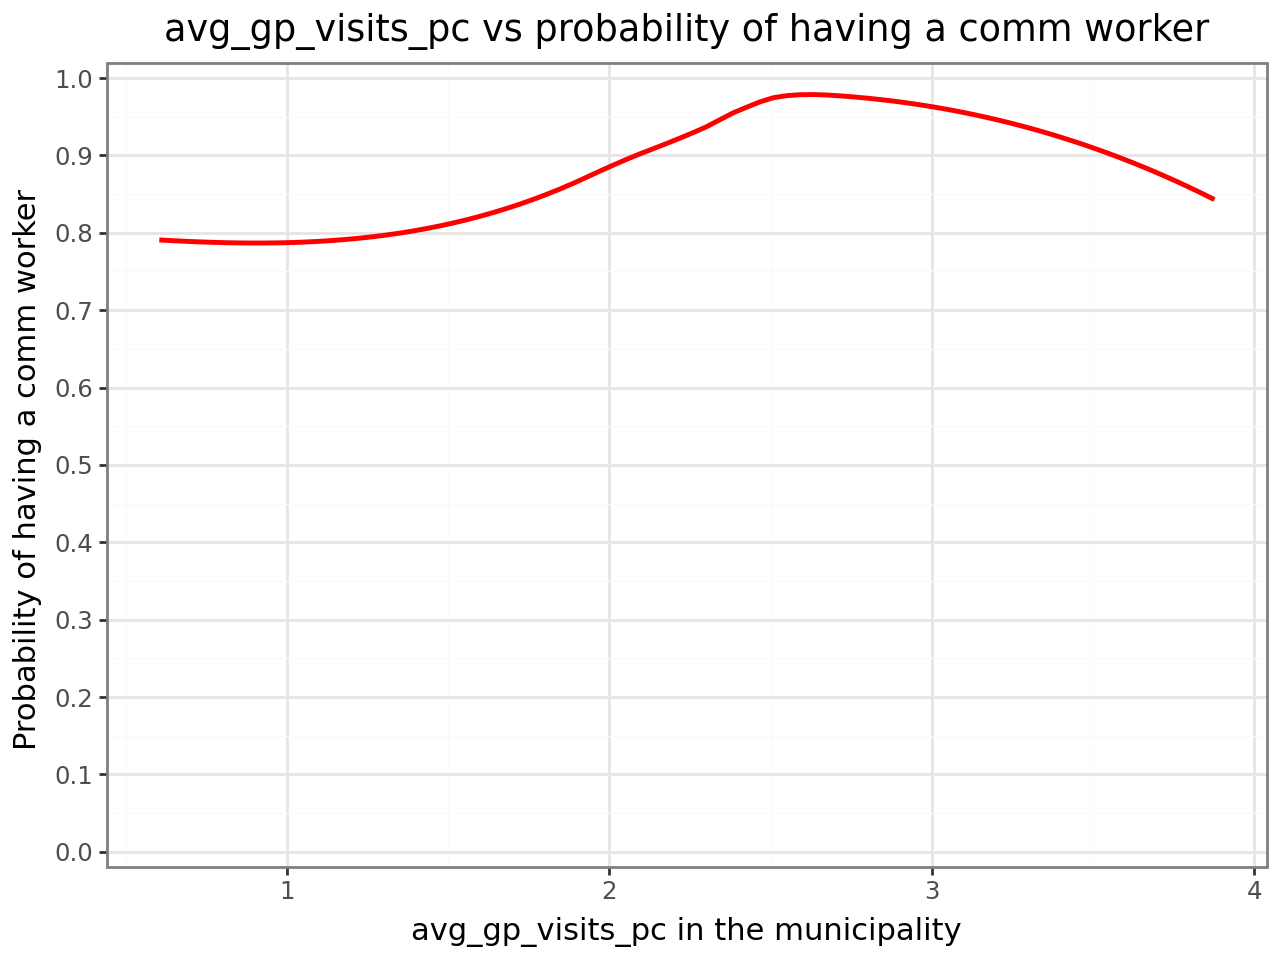

In [294]:
(
    ggplot(data=train)
    + geom_smooth(
        aes(x="avg_gp_visits_pc", y="has_comm_worker"), method="loess", se=False, color="red"
    )
    + labs(
        x="avg_gp_visits_pc in the municipality", y="Probability of having a comm worker ", title="avg_gp_visits_pc vs probability of having a comm worker"
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)

2,5höz spline

In [295]:
pd.crosstab(index = train['has_comm_worker'],columns= train['no_elem_stud'])

no_elem_stud,0,1
has_comm_worker,,
0,59,125
1,1331,1007


This model includes all variables without taking the logarithm of them

In [297]:
lpm1 = smf.ols("has_comm_worker ~ is_county_center+romani_ratio+monthly_income_pc+unemp_ratio+hprest_emp_ratio+agr_emp_ratio+pop_density+old_age_dependency_ratio+gen_dependency_ratio+migration_per1000+growth_decline_per1000+max_elem_educ_ratio+disadv_elem_students_ratio+elem_stud_from_other_muni_ratio+county_center_min+low_comf_housing_ratio+crime_per1000people+avg_gp_visits_pc+no_elem_stud", 
               data=train).fit(cov_type ="HC1")
print(lpm1.summary())

                            OLS Regression Results                            
Dep. Variable:        has_comm_worker   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     12.60
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           4.63e-38
Time:                        09:46:28   Log-Likelihood:                 25.661
No. Observations:                2522   AIC:                            -11.32
Df Residuals:                    2502   BIC:                             105.3
Df Model:                          19                                         
Covariance Type:                  HC1                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

With romani_ratio logaritmic

In [361]:
lpm2 = smf.ols("has_comm_worker ~ is_county_center+ln_romani_ratio+romani_zero_flag+monthly_income_pc+unemp_ratio+hprest_emp_ratio+agr_emp_ratio+pop_density+old_age_dependency_ratio+gen_dependency_ratio+migration_per1000+growth_decline_per1000+max_elem_educ_ratio+disadv_elem_students_ratio+elem_stud_from_other_muni_ratio+county_center_min+low_comf_housing_ratio+crime_per1000people+avg_gp_visits_pc+no_elem_stud", 
               data=train).fit(cov_type ="HC1")
print(lpm2.summary())

                            OLS Regression Results                            
Dep. Variable:        has_comm_worker   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     12.51
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           1.67e-39
Time:                        11:04:02   Log-Likelihood:                 59.301
No. Observations:                2522   AIC:                            -76.60
Df Residuals:                    2501   BIC:                             45.89
Df Model:                          20                                         
Covariance Type:                  HC1                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Many of our variables are indicators for the well being of the municipality which can cause multicollinearity. For the better understanding I visualize the correlation between the variables.

In [300]:
non_binary_variables = [
    "romani_ratio", "monthly_income_pc", "unemp_ratio", "hprest_emp_ratio", "agr_emp_ratio", 
    "pop_density", "old_age_dependency_ratio", "gen_dependency_ratio", "migration_per1000", 
    "growth_decline_per1000", "max_elem_educ_ratio", "disadv_elem_students_ratio", 
    "elem_stud_from_other_muni_ratio", "county_center_min", "low_comf_housing_ratio", 
    "crime_per1000people", "avg_gp_visits_pc"
]

df_selected = tidy[non_binary_variables]

# Compute the correlation matrix
correlation_matrix = df_selected.corr()
correlation_matrix.round(2)

,romani_ratio,monthly_income_pc,unemp_ratio,hprest_emp_ratio,agr_emp_ratio,pop_density,old_age_dependency_ratio,gen_dependency_ratio,migration_per1000,growth_decline_per1000,max_elem_educ_ratio,disadv_elem_students_ratio,elem_stud_from_other_muni_ratio,county_center_min,low_comf_housing_ratio,crime_per1000people,avg_gp_visits_pc
romani_ratio,1.00,-0.48,0.14,-0.35,0.09,-0.08,-0.37,0.03,-0.12,0.19,0.55,0.18,-0.08,0.10,0.27,0.21,-0.04
monthly_income_pc,-0.48,1.00,-0.22,0.61,-0.21,0.38,0.05,-0.14,0.19,0.02,-0.72,-0.24,0.18,-0.30,-0.35,-0.20,0.01
unemp_ratio,0.14,-0.22,1.00,-0.15,0.06,-0.08,-0.04,-0.02,-0.09,-0.04,0.24,0.12,-0.03,0.11,0.14,0.08,0.07
hprest_emp_ratio,-0.35,0.61,-0.15,1.00,-0.24,0.40,0.25,0.11,0.12,-0.04,-0.69,-0.22,0.13,-0.19,-0.27,-0.06,-0.10
agr_emp_ratio,0.09,-0.21,0.06,-0.24,1.00,-0.16,-0.01,0.06,-0.05,0.05,0.26,0.03,-0.07,0.10,0.17,-0.01,-0.04
pop_density,-0.08,0.38,-0.08,0.40,-0.16,1.00,-0.07,-0.03,0.06,0.09,-0.32,-0.03,0.09,-0.14,-0.14,0.01,-0.03
old_age_dependency_ratio,-0.37,0.05,-0.04,0.25,-0.01,-0.07,1.00,0.58,0.06,-0.45,-0.22,-0.16,0.03,0.08,-0.12,-0.06,0.20
gen_dependency_ratio,0.03,-0.14,-0.02,0.11,0.06,-0.03,0.58,1.00,0.06,-0.19,-0.00,0.02,0.02,0.09,0.02,0.05,0.18
migration_per1000,-0.12,0.19,-0.09,0.12,-0.05,0.06,0.06,0.06,1.00,-0.05,-0.17,-0.07,0.02,-0.08,-0.12,-0.04,0.01
growth_decline_per1000,0.19,0.02,-0.04,-0.04,0.05,0.09,-0.45,-0.19,-0.05,1.00,0.03,0.08,0.01,-0.09,-0.00,0.04,-0.22


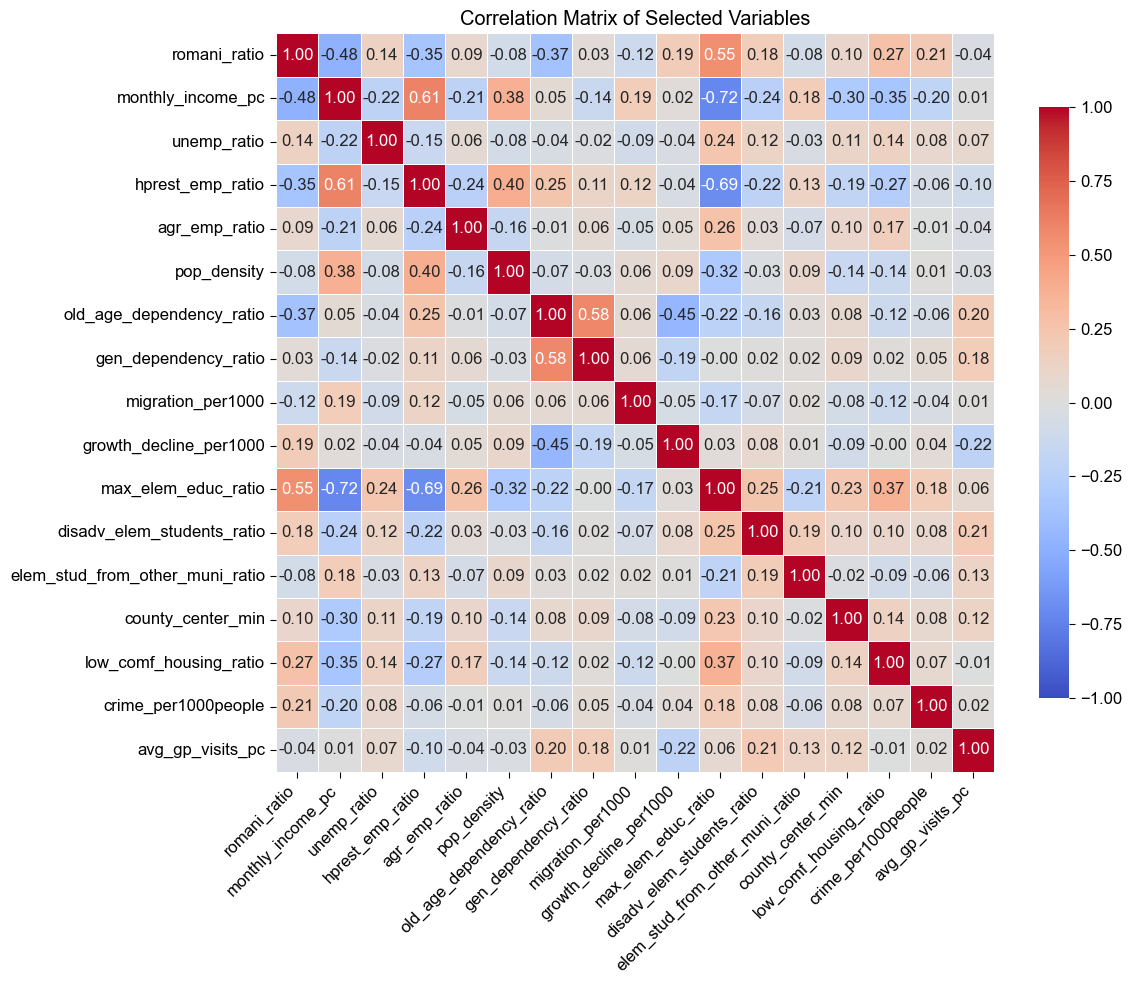

In [302]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, 
    annot=True, fmt=".2f", cmap="coolwarm", 
    vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Matrix of Selected Variables")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

|0.3-0.4|
    romani_ratio : hprest_emp_ratio	
    romani_ratio : old_age_dependency_ratio
    monthly_income_pc : county_center_min
    monthly_income_pc : low_comf_housing_ratio
    pop_density : max_elem_educ_ratio
    max_elem_educ_ratio : low_comf_housing_ration
    
|0.4-0.5|
    romani_ratio : monthly_income_pc
    monthly_income_pc : pop_density
    hprest_emp_ratio : pop_density
    old_age_dependency_ratio : growth_decline_per1000
    
|0.5-0.6|
    romani_ratio : max_elem_educatio
    hprest_emp_ratio : max_elem_educatio
    old_age_dependency_ratio : gen_dependecy_ratio
    
|0.6-0.7|
    monthly_income_pc : hprest_emp_ratio

|0.7-0.8|
    monthly_income_pc : max_elem_educ_ratio

Unemp ratio is not correlated with anything.
Agr_emp_ratio is nor correlated with anything.
Even though romani_ratio is correlated with many variables, it is one of our main variables so we don't consider it to make it part of principal component analysis.

1. Education
    max_elem_educ_ratio
    disadv_elem_students_ratio
    elem_stud_from_other_muni_ratio

2. Health and safety
    low_comf_housing_ratio
    crime_per1000people
    avg_gp_visits_pc

3. migration and mobility
    migration_per1000
    growth_decline_per1000
    county_center_min
    pop_density
   
4. job composition and status
    monthly_income_pc
    unemp_ratio
    hprest_emp_ratio
    agr_emp_ratio
   
5. demographic composition
    old_age_dependency_ratio
    gen_dependency_ratio

1. population composition
    unemp_ratio
    hprest_emp_ratio
    agr_emp_ratio
    old_age_dependency_ratio
    gen_dependency_ratio
    monthly_income_pc
    
3. migration and mobility
    migration_per1000
    growth_decline_per1000
    county_center_min
    pop_density

4. Education
    max_elem_educ_ratio
    disadv_elem_students_ratio
    elem_stud_from_other_muni_ratio

5. Health and safety
    low_comf_housing_ratio
    crime_per1000people
    avg_gp_visits_pc

For principal component analysis it is important to scale the variables first.

In [317]:
variables_to_scale = [
     "monthly_income_pc", "unemp_ratio", "hprest_emp_ratio", "agr_emp_ratio", 
    "pop_density", "old_age_dependency_ratio", "gen_dependency_ratio", "migration_per1000", 
    "growth_decline_per1000", "max_elem_educ_ratio", "disadv_elem_students_ratio", 
    "elem_stud_from_other_muni_ratio", "county_center_min", "low_comf_housing_ratio", 
    "crime_per1000people", "avg_gp_visits_pc"
]

for var in variables_to_scale:
    train[f"scaled_{var}"] = (train[var] - train[var].mean()) / train[var].std()

# Check the result
train.head()


,muni_id,muni_name,status,is_county_center,county,district,comm_work_per_employed,romani_ratio,monthly_income_pc,unemp_ratio,...,scaled_gen_dependency_ratio,scaled_migration_per1000,scaled_growth_decline_per1000,scaled_max_elem_educ_ratio,scaled_disadv_elem_students_ratio,scaled_elem_stud_from_other_muni_ratio,scaled_county_center_min,scaled_low_comf_housing_ratio,scaled_crime_per1000people,scaled_avg_gp_visits_pc
1297,383,Keszü,község,0,Baranya,Pécsi,0.012839,0.0095,225061.853359,0.4286,...,-0.895741,0.458431,1.054404,-1.424421,-0.536982,-0.646008,-1.557893,-0.311408,-0.237790,-0.746740
2314,451,Rózsafa,község,0,Baranya,Szigetvári,0.070922,0.1610,84497.613636,0.5625,...,0.251629,-0.827728,1.881225,1.460007,-0.536982,-0.646008,-0.550925,-0.699686,0.818184,-0.173278
765,758,Felsőregmec,község,0,Borsod-Abaúj-Zemplén,Sátoraljaújhelyi,0.403846,0.6696,51847.948052,0.6136,...,0.872247,0.330625,3.111165,2.823077,-0.536982,-0.646008,2.160669,3.042651,-0.779595,-0.770617
2954,1458,Vámosgyörk,község,0,Heves,Gyöngyösi,0.016260,0.0146,184430.903537,0.5946,...,1.657405,0.921078,-2.007579,-0.449161,-0.417133,0.370783,0.198935,0.015500,-0.186155,1.644622
2808,337,Tiszapüspöki,község,0,Jász-Nagykun-Szolnok,Törökszentmiklósi,0.069393,0.1532,113463.144541,0.4722,...,-0.232055,-0.958715,0.801383,0.700044,2.761736,-0.646008,-1.083193,0.417940,0.097474,-0.494513


In [321]:
columns_to_use = ["scaled_max_elem_educ_ratio", "scaled_disadv_elem_students_ratio", "scaled_elem_stud_from_other_muni_ratio"]
pca = PCA()

# Fit and transform the selected columns
pca_educ = pca.fit_transform(train[columns_to_use])

for i in range(pca_educ.shape[1]):
    train[f"pca_educ_{i+1}"] = pca_educ[:, i]

columns_to_use = ["scaled_low_comf_housing_ratio", "scaled_crime_per1000people", "scaled_avg_gp_visits_pc"]
pca_health_safety = pca.fit_transform(train[columns_to_use])
for i in range(pca_health_safety.shape[1]):
    train[f"pca_health_safety{i+1}"] = pca_health_safety[:, i]

columns_to_use = ["scaled_migration_per1000", "scaled_growth_decline_per1000", "scaled_county_center_min", "scaled_pop_density"]
pca_migration_moblility = pca.fit_transform(train[columns_to_use])
for i in range(pca_migration_moblility.shape[1]):
    train[f"pca_migration_moblility{i+1}"] = pca_migration_moblility[:, i]

columns_to_use = ["scaled_monthly_income_pc", "scaled_unemp_ratio", "scaled_hprest_emp_ratio", "scaled_agr_emp_ratio"]
pca_job_comp = pca.fit_transform(train[columns_to_use])
for i in range(pca_job_comp.shape[1]):
    train[f"pca_job_comp{i+1}"] = pca_job_comp[:, i]   

columns_to_use = ["scaled_old_age_dependency_ratio", "scaled_gen_dependency_ratio"]
pca_demog = pca.fit_transform(train[columns_to_use])
for i in range(pca_demog.shape[1]):
    train[f"pca_demog{i+1}"] = pca_demog[:, i] 

In [324]:
pca_lpm = smf.ols("has_comm_worker ~ romani_ratio+is_county_center+no_elem_stud+pca_educ_1+pca_health_safety1+pca_migration_moblility1+pca_job_comp1+pca_demog1", 
               data=train).fit(cov_type ="HC1")
print(pca_lpm.summary())

                            OLS Regression Results                            
Dep. Variable:        has_comm_worker   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     26.00
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           6.13e-39
Time:                        09:46:41   Log-Likelihood:                -20.157
No. Observations:                2522   AIC:                             58.31
Df Residuals:                    2513   BIC:                             110.8
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

1. Education positive: elem_stud_from_other_muni_ratio
2. Education negative:
    max_elem_educ_ratio
    disadv_elem_students_ratio
    

3. Health and safety negative
    low_comf_housing_ratio
    crime_per1000people
    avg_gp_visits_pc

4. migration and mobility positive
    migration_per1000
    growth_decline_per1000
    pop_density
   
6. migration and mobility negative
    county_center_min
    
7. job composition and status positive
    monthly_income_pc
    hprest_emp_ratio
   
9. job composition and status negative
    unemp_ratio
    agr_emp_ratio
   
10. demographic composition
    old_age_dependency_ratio
    gen_dependency_ratio

In [348]:
train = train[["muni_name", "status", "is_county_center", "county", "district", "comm_work_per_employed", "romani_ratio", "monthly_income_pc", "unemp_ratio", "hprest_emp_ratio",
              "agr_emp_ratio", "pop_density", "old_age_dependency_ratio", "gen_dependency_ratio", "migration_per1000", "growth_decline_per1000", "max_elem_educ_ratio", "disadv_elem_students_ratio",
               "elem_stud_from_other_muni_ratio", "county_center_min", "low_comf_housing_ratio", "crime_per1000people", "avg_gp_visits_pc", "no_elem_stud", "ln_romani_ratio", "romani_zero_flag",
              "has_comm_worker", "scaled_monthly_income_pc", "scaled_unemp_ratio", "scaled_hprest_emp_ratio", "scaled_agr_emp_ratio", "scaled_pop_density", "scaled_old_age_dependency_ratio",
               "scaled_gen_dependency_ratio", "scaled_migration_per1000", "scaled_growth_decline_per1000","scaled_max_elem_educ_ratio", "scaled_disadv_elem_students_ratio", "scaled_elem_stud_from_other_muni_ratio",
               "scaled_county_center_min", "scaled_low_comf_housing_ratio", "scaled_crime_per1000people", "scaled_avg_gp_visits_pc"]]

In [352]:
columns_to_use = ["scaled_max_elem_educ_ratio", "scaled_disadv_elem_students_ratio"]
pca = PCA()
pca_educ = pca.fit_transform(train[columns_to_use])
for i in range(pca_educ.shape[1]):
    train[f"pca_educ_{i+1}"] = pca_educ[:, i]

columns_to_use = ["scaled_low_comf_housing_ratio", "scaled_crime_per1000people", "scaled_avg_gp_visits_pc"]
pca_health_safety = pca.fit_transform(train[columns_to_use])
for i in range(pca_health_safety.shape[1]):
    train[f"pca_health_safety{i+1}"] = pca_health_safety[:, i]

columns_to_use = ["scaled_migration_per1000", "scaled_growth_decline_per1000", "scaled_pop_density"]
pca_migration_moblility = pca.fit_transform(train[columns_to_use])
for i in range(pca_migration_moblility.shape[1]):
    train[f"pca_migration_moblility{i+1}"] = pca_migration_moblility[:, i]

columns_to_use = ["scaled_monthly_income_pc", "scaled_hprest_emp_ratio"]
pca_job_comp_pos = pca.fit_transform(train[columns_to_use])
for i in range(pca_job_comp_pos.shape[1]):
    train[f"pca_job_comp_pos{i+1}"] = pca_job_comp_pos[:, i]

columns_to_use = [ "scaled_unemp_ratio", "scaled_agr_emp_ratio"]
pca_job_comp_neg = pca.fit_transform(train[columns_to_use])
for i in range(pca_job_comp_neg.shape[1]):
    train[f"pca_job_comp_neg{i+1}"] = pca_job_comp_neg[:, i]

columns_to_use = ["scaled_old_age_dependency_ratio", "scaled_gen_dependency_ratio"]
pca_demog = pca.fit_transform(train[columns_to_use])
for i in range(pca_demog.shape[1]):
    train[f"pca_demog{i+1}"] = pca_demog[:, i] 

In [354]:
pca_positive_negative = smf.ols("has_comm_worker ~ romani_ratio+is_county_center+no_elem_stud+elem_stud_from_other_muni_ratio+pca_educ_1+county_center_min+pca_health_safety1+pca_migration_moblility1+pca_job_comp_pos1+pca_job_comp_neg1+pca_demog1", 
               data=train).fit(cov_type ="HC1")
print(pca_positive_negative.summary())

                            OLS Regression Results                            
Dep. Variable:        has_comm_worker   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     19.28
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           1.11e-37
Time:                        10:02:00   Log-Likelihood:                -15.923
No. Observations:                2522   AIC:                             55.85
Df Residuals:                    2510   BIC:                             125.8
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Same model but with nonlinear pattern for romani ratio

In [449]:
pca_lnromani = smf.ols("has_comm_worker ~ ln_romani_ratio*romani_zero_flag+is_county_center+no_elem_stud+elem_stud_from_other_muni_ratio+pca_educ_1+county_center_min+pca_health_safety1+pca_migration_moblility1+pca_job_comp_pos1+pca_job_comp_neg1+pca_demog1", 
               data=train).fit(cov_type ="HC1")
print(pca_lnromani.summary())

                            OLS Regression Results                            
Dep. Variable:        has_comm_worker   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     18.80
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           1.27e-39
Time:                        17:19:36   Log-Likelihood:                 23.117
No. Observations:                2522   AIC:                            -20.23
Df Residuals:                    2509   BIC:                             55.59
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

Biztos lehet ln és spline egyszerre?

In [359]:
pca_spline_lnromani = smf.ols("has_comm_worker ~ lspline(ln_romani_ratio,[4.5])+romani_zero_flag+is_county_center+no_elem_stud+elem_stud_from_other_muni_ratio+pca_educ_1+county_center_min+pca_health_safety1+pca_migration_moblility1+pca_job_comp_pos1+pca_job_comp_neg1+pca_demog1", 
               data=train).fit(cov_type ="HC1")
print(pca_spline_lnromani.summary())

                            OLS Regression Results                            
Dep. Variable:        has_comm_worker   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     18.80
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           1.27e-39
Time:                        10:54:14   Log-Likelihood:                 23.117
No. Observations:                2522   AIC:                            -20.23
Df Residuals:                    2509   BIC:                             55.59
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

Without pca but non linear patterns

Monthly incomre milyen függvényt? van pár ami belkerülhetne, csak nem tudom milyen függvényben, lehet splinet és kvadratikust keverni?

In [397]:
non_linear = smf.ols("has_comm_worker ~ ln_romani_ratio+romani_zero_flag+is_county_center+no_elem_stud+unemp_ratio+I(unemp_ratio**2)+hprest_emp_ratio+lspline(pop_density, [50])+old_age_dependency_ratio+gen_dependency_ratio+I(gen_dependency_ratio**2)+lspline(migration_per1000,[0])+lspline(max_elem_educ_ratio, [0.3])+county_center_min", 
               data=train).fit(cov_type ="HC1")
print(non_linear.summary())

                            OLS Regression Results                            
Dep. Variable:        has_comm_worker   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     15.99
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           3.26e-45
Time:                        11:34:51   Log-Likelihood:                 120.26
No. Observations:                2522   AIC:                            -204.5
Df Residuals:                    2504   BIC:                            -99.54
Df Model:                          17                                         
Covariance Type:                  HC1                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [411]:
non_linear_only_sign = smf.ols("has_comm_worker ~ ln_romani_ratio+romani_zero_flag+is_county_center+no_elem_stud+unemp_ratio+I(unemp_ratio**2)+hprest_emp_ratio+lspline(pop_density, [50])+gen_dependency_ratio+I(gen_dependency_ratio**2)+lspline(max_elem_educ_ratio, [0.3])", 
               data=train).fit(cov_type ="HC1")
print(non_linear_only_sign.summary())

                            OLS Regression Results                            
Dep. Variable:        has_comm_worker   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     20.87
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           1.27e-47
Time:                        11:40:37   Log-Likelihood:                 118.34
No. Observations:                2522   AIC:                            -208.7
Df Residuals:                    2508   BIC:                            -127.0
Df Model:                          13                                         
Covariance Type:                  HC1                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [344]:
train.iloc[:, 40:70].head().T

,1297,2314,765,2954,2808
weight_2,0.005000,0.001000,0.001000,0.006000,0.001000
pred_logit,0.908489,0.999775,1.000000,0.924196,0.999692
pred_lev_log,0.949921,1.002780,1.029400,0.957947,1.001852
pred_spline,0.913675,0.971713,1.166551,0.915628,0.968724
scaled_monthly_income_pc,1.826351,-1.336507,-2.071163,0.912108,-0.684749
scaled_unemp_ratio,-0.470268,0.217803,0.480391,0.382755,-0.246221
scaled_hprest_emp_ratio,3.184249,-0.641870,-1.675098,-0.142300,-0.532552
scaled_agr_emp_ratio,-0.664768,-0.257468,-0.664768,-0.598068,-0.166621
scaled_pop_density,0.995765,-0.405876,-0.294214,0.148672,-0.137077
scaled_old_age_dependency_ratio,-1.031692,-1.287183,-2.560593,1.134495,-0.882526
